# Analyzing the composition of the mantle zone

The germinal centers were easily identified in neighborhood analysis, but, their mantle zones seemed distinct among disease tpyes

approach:
1. cluster germinal center cells based on their known labels
    - use convex hull approach
2. expand the encompassing polygon by an arbitrary distance
3. make a new donut shape
4. count relative cell abundance within the "donut"/mantle

ALSO TRY CONTOUR APPROACH

--CD--
Motif 2 is follicle, in MCD, Motif 4 is also follicle


In [1]:
import tifffile as tff
import re
# from cv2 import imwrite
import pandas as pd
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
import matplotlib as mplb
import matplotlib.cm as cm
from tqdm import tqdm
from imantics import Polygons, Mask
import geojson as gjson
import argparse
from scipy import signal, ndimage
import scipy as sci
import random
import os
import anndata as ad
from PIL import Image

from scipy.spatial import ConvexHull, convex_hull_plot_2d
from skimage.draw import polygon2mask
import shapely as shp
import geopandas as gpd

import seaborn as sns
import matplotlib as mpl

ERROR 1: PROJ: proj_create_from_database: Open of /home/smithd30/miniconda3/envs/imageAnalysis/share/proj failed


In [2]:
codex = ad.read_h5ad("/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/code/CD_analysis/aSMA_CD21_analysis/all_regions_dat.h5ad")
codex

AnnData object with n_obs × n_vars = 3895114 × 38
    obs: 'Unnamed: 0', 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Reg', 'Tile.Row', 'Tile.Col', 'Tile.Z', 'In.Tile.Y', 'In.Tile.X', 'Absolute.Y', 'Absolute.X', 'Cell.Size', 'n_genes_by_counts', 'total_counts', 'nCount_raw', 'nFeature_raw', 'cell_type_pred_knn', 'cell_type_pred_knn_prob', 'motif', 'index_info', 'new_pheno', 'region'
    uns: 'lda_10', 'lda_10_probability', 'lda_12', 'lda_12_probability', 'lda_15', 'lda_15_probability', 'lda_8', 'lda_8_probability', 'spatial_lda', 'spatial_lda_probability'

In [3]:
codex.obs.motif.unique()

['Motif_3', 'Motif_8', 'Motif_9', 'Motif_7', 'Motif_1', ..., 'Motif_6', 'Motif_5', 'Motif_2', 'Motif_4', 'Motif_11']
Length: 12
Categories (12, object): ['Motif_0', 'Motif_1', 'Motif_2', 'Motif_3', ..., 'Motif_8', 'Motif_9', 'Motif_10', 'Motif_11']

# Testing...

## clustering follicle cells 

Start with 50 pixel distance...too many
100 pixels seems like a good distance

In [3]:
# testing with MCD1
adata = codex[codex.obs.region == "MCD1_reg1",:].copy()
# codex.obs.region.unique()

In [13]:
img = tff.TiffFile('../forQuPath/Data/MCD1_reg1/full_input_codex.qptiff')
img.__dict__.keys()

dict_keys(['_omexml', '_fh', '_multifile', '_files', '_decoders', '_parent', 'tiff', 'pages', 'is_lsm', 'is_scanimage', 'is_philips', 'is_ndpi'])

In [111]:
img.pages[0].shape

(9504, 10031)

In [54]:
coords = adata.obs[['Absolute.Y', 'Absolute.X']].to_numpy() # should it be X,Y or Y,X ????
coords = coords[adata.obs.motif.isin(['Motif_2', 'Motif_4']),:]
coords.shape

(11209, 2)

In [40]:
# approach 1
clustered = []
follicle_dict = {"cl0":[]}
ci = 0
for i in tqdm(range(coords.shape[0])):
    if i not in clustered:
        i_dist = np.linalg.norm(coords[i]-coords, axis=1)
        i_neighbor = np.where(i_dist < 100)[0].tolist()
        # should we check whether any of the neighbors are in the clustered list?
        # i_neighbor = i_neighbor[~list(map(lambda i_: i_ in clustered, i_neighbor))]
        clustered.extend(i_neighbor)
        
        new_cl_token = 1
        for cl, _ in follicle_dict.items():
            if any(list(map(lambda x: x in _, i_neighbor))):
                new_cl_token = 0
                cell_set = set(follicle_dict[cl])
                new_set = set(cell_set).union(i_neighbor)
                follicle_dict[cl] = list(new_set)
                # break
        if new_cl_token == 1:
            follicle_dict["cl"+str(ci+1)] = i_neighbor
            ci += 1

100%|██████████| 11209/11209 [00:02<00:00, 4992.27it/s]


In [41]:
cluster_sizes = [len(x) for cl, x in follicle_dict.items()]
np.quantile(cluster_sizes, np.arange(0,1,0.1))
# so most are random garbage

array([  0. ,   1. ,   1. ,   2.1,   8. ,  20. ,  62.6, 146.8, 291.6,
       409.3])

In [55]:
# Approach 2
clustered = []
follicle_sets = []
for i in tqdm(range(coords.shape[0])):
    if i not in clustered:
        i_dist = np.linalg.norm(coords[i]-coords, axis=1)
        i_neighbor = np.where(i_dist < 100)[0].tolist()
        # should we check whether any of the neighbors are in the clustered list?
        # i_neighbor = i_neighbor[~list(map(lambda i_: i_ in clustered, i_neighbor))]
        clustered.extend(i_neighbor)
        
        new_cl_token = 1
        fs_hits = [fi for fi in range(len(follicle_sets)) if len(set(follicle_sets[fi]).intersection(i_neighbor)) > 0]
        if len(fs_hits) > 0:
            cell_set = []
            for fi in sorted(fs_hits, reverse=True):
                cell_set.extend(follicle_sets[fi])
                follicle_sets.pop(fi)
            cell_set = set(cell_set).union(i_neighbor)
            follicle_sets.append(cell_set)
        else:
            follicle_sets.append(i_neighbor)

100%|██████████| 11209/11209 [00:00<00:00, 13051.37it/s]


In [56]:
# len(follicle_sets)
fsizes = [len(x) for x in follicle_sets]
np.quantile(fsizes, np.arange(0,1,0.1))

array([  1. ,   1. ,   1. ,   1. ,   2. ,   3. ,   6. ,  11.2,  49.8,
       269.5])

## Filtering and Visualizing the follicles
only keep follicles with more than 50 cells

In [57]:
# old way...
# keep_i = []
# cl_data = []
# cl_value = 1
# for c, i in follicle_dict.items():
#     if len(i) > 50:
#         keep_i.extend(i)
#         cl_data.extend(np.repeat(cl_value, len(i)))
#         cl_value += 1
# cl_data = np.array(cl_data)

# new way...
f_clust = []
keep_i = []
cl_i = 1
for fs in follicle_sets:
    if len(fs) > 100:
        f_clust.extend(np.repeat(cl_i, len(fs)))
        keep_i.extend(fs)
        cl_i += 1
follicle_filt = pd.DataFrame({'f_clust':f_clust,
                             'celli':keep_i})
follicle_filt.tail()

f_clust  celli
10225       17  11164
10226       17  11165
10227       17  11166
10228       17  11168
10229       17  10226

In [58]:
coords_keep = coords[follicle_filt.celli.values,:]
coords_keep.shape

(10230, 2)

## Making the mantle shape

In [59]:
coords_test = coords[follicle_filt.celli.loc[follicle_filt.f_clust==1].values,:]
coords_test.shape

(885, 2)

In [60]:
foll_hull = ConvexHull(coords_test)

In [123]:
np.flip(foll_hull.points[foll_hull.vertices], 1)

array([[ 775.69135802, 4272.87037037],
       [ 772.99473684, 4532.66842105],
       [ 800.94936709, 4682.11708861],
       [1180.17605634, 4868.28873239],
       [1213.44324324, 4884.51891892],
       [1384.1744186 , 4924.5755814 ],
       [1485.25      , 4827.35135135],
       [1567.59210526, 4574.51315789],
       [1608.        , 4418.61827957],
       [1513.81641469, 4197.10583153],
       [1494.36231884, 4185.76811594],
       [1270.52422907, 4086.73568282],
       [1198.63291139, 4071.03164557],
       [1085.46060606, 4082.80606061],
       [1067.1402439 , 4088.42073171],
       [1052.77824268, 4092.84518828],
       [ 903.48818898, 4156.95275591]])

In [67]:
# coord_m = sci.sparse.csr_array((cl_data, (coords_keep[:,0], coords_keep[:,1])))
# coord_m = (coord_m/coord_m.max())*255
# coord_m = sci.sparse.csr_array((np.repeat(1, coords_all.shape[0]), (coords_all[:,0], coords_all[:,1])), dtype=np.uint)


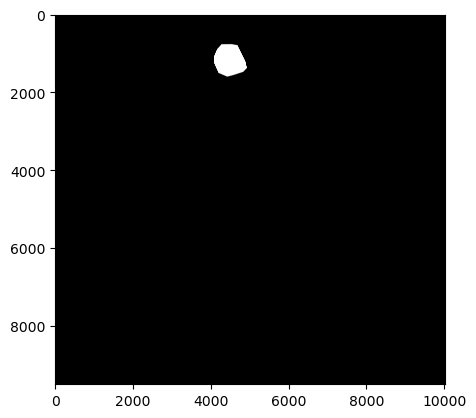

In [61]:

image_shape = img.pages[0].shape

# mantle - foll_poly
mask = polygon2mask(image_shape, np.flip(foll_hull.points[foll_hull.vertices], 1))
dat_ = np.zeros(image_shape)
dat_[mask] = 255
plt.imshow(dat_, cmap='gray')

In [62]:
all_coords = adata.obs[['Absolute.Y', 'Absolute.X']].to_numpy()

foll_geom = np.flip(foll_hull.points[foll_hull.vertices], 1)
foll_poly = shp.Polygon(foll_geom)
mantle = foll_poly.buffer(200, single_sided=True)

all_coords = gpd.points_from_xy(x=all_coords[:,1], y=all_coords[:,0])
mantle_c = all_coords.within(mantle - foll_poly)
mantle_c.sum()

1334

In [65]:
adata.obs[['Absolute.Y', 'Absolute.X']].loc[mantle_c].head()

Absolute.Y   Absolute.X
76843_MCD1_reg1  3988.402597   896.961039
76865_MCD1_reg1  3966.684971  1025.786127
76901_MCD1_reg1  3946.592885   984.624506
76943_MCD1_reg1  3915.653061   985.795918
77000_MCD1_reg1  3954.106122   932.722449

In [64]:
coords_test

array([[4532.66842105,  772.99473684],
       [4272.87037037,  775.69135802],
       [4497.7172619 , 1418.53869048],
       ...,
       [4764.65454545, 1307.10909091],
       [4808.13380282, 1426.28873239],
       [4852.28699552, 1397.29147982]])

In [18]:
adata.obs.new_pheno.loc[mantle_c].value_counts()

new_pheno
CD4_T_Cell          347
Endothelial         277
B_Cell              266
pDC                 161
Macrophage          125
CD8_T_Cell           86
cDC2                 21
Plasma_Cell          18
Stromal              17
Cytotoxic_T_Cell      7
T_cell                3
myeloid               3
cDC1                  1
Tfh                   1
Treg                  1
Mast_Cell             0
Neutrophil            0
Lymphatics            0
immune                0
Name: count, dtype: int64

In [20]:
# summary data
pd.DataFrame({'donor':'MCD1', 'region':'reg1', 'follicle':'fl1', 
             'cells': adata.obs.new_pheno.loc[mantle_c].value_counts().values,
             'cell_type': adata.obs.new_pheno.loc[mantle_c].value_counts().index})

donor region follicle  cells         cell_type
0   MCD1   reg1      fl1    347        CD4_T_Cell
1   MCD1   reg1      fl1    277       Endothelial
2   MCD1   reg1      fl1    266            B_Cell
3   MCD1   reg1      fl1    161               pDC
4   MCD1   reg1      fl1    125        Macrophage
5   MCD1   reg1      fl1     86        CD8_T_Cell
6   MCD1   reg1      fl1     21              cDC2
7   MCD1   reg1      fl1     18       Plasma_Cell
8   MCD1   reg1      fl1     17           Stromal
9   MCD1   reg1      fl1      7  Cytotoxic_T_Cell
10  MCD1   reg1      fl1      3            T_cell
11  MCD1   reg1      fl1      3           myeloid
12  MCD1   reg1      fl1      1              cDC1
13  MCD1   reg1      fl1      1               Tfh
14  MCD1   reg1      fl1      1              Treg
15  MCD1   reg1      fl1      0         Mast_Cell
16  MCD1   reg1      fl1      0        Neutrophil
17  MCD1   reg1      fl1      0        Lymphatics
18  MCD1   reg1      fl1      0            immune

## Putting 1 sample together

In [ ]:
all_coords = adata.obs[['Absolute.Y', 'Absolute.X']].to_numpy()
all_coords = gpd.points_from_xy(x=all_coords[:,1], y=all_coords[:,0])

In [68]:
fl_dfs = []
for f in tqdm(follicle_filt.f_clust.unique()):
    coords_test = coords[follicle_filt.celli.loc[follicle_filt.f_clust==f].values,:]
    foll_hull = ConvexHull(coords_test)
    foll_geom = np.flip(foll_hull.points[foll_hull.vertices], 1)
    foll_poly = shp.Polygon(foll_geom)
    mantle = foll_poly.buffer(200, single_sided=True)
    mantle_c = all_coords.within(mantle - foll_poly)
    res_df = pd.DataFrame({'donor':'MCD1', 
                           'region':'reg1', 
                           'follicle':'fl'+str(f), 
                           'cells': adata.obs.new_pheno.loc[mantle_c].value_counts().values,
                           'cell_type': adata.obs.new_pheno.loc[mantle_c].value_counts().index})
    fl_dfs.append(res_df)

100%|██████████| 17/17 [00:13<00:00,  1.26it/s]


In [69]:
fl_df = pd.concat(fl_dfs, axis=0, ignore_index=True)
fl_df.shape

(323, 5)

# Visulaize mantle results

In [5]:
full_r = "HVCD2_reg2"
adata = codex[codex.obs.region == full_r,:].copy()
adata.obs['follicle'] = 0
adata.obs['follicle_level'] = -1
adata.obs['follicle_area'] = 0
fuse_dat = ad.read_h5ad("../maxfuse/maxfuse_out/"+full_r+"fuse_anno.h5ad")
fuse_dat.obs_names = ["_".join([bc,full_r]) for bc in fuse_dat.obs_names.tolist()]
# adata = adata[fuse_dat.obs_names,:]
adata.obs["fuse_pheno"] = adata.obs.new_pheno.astype(str)
adata.obs.loc[fuse_dat.obs_names, "fuse_pheno"] = fuse_dat.obs.fuse_pheno


all_coords = adata.obs[['Absolute.Y', 'Absolute.X']].to_numpy()
all_coords = gpd.points_from_xy(x=all_coords[:,1], y=all_coords[:,0])
r_ = full_r.split("_")
sname = r_[0]
regname = r_[1]

# getting the data
coords = adata.obs[['Absolute.Y', 'Absolute.X']].to_numpy() # should it be X,Y or Y,X ????
coords = coords[adata.obs.motif.isin(['Motif_2', 'Motif_4']),:]

# getting the follicles
clustered = []
follicle_sets = []
for i in range(coords.shape[0]):
    if i not in clustered:
        i_dist = np.linalg.norm(coords[i]-coords, axis=1)
        i_neighbor = np.where(i_dist < 50)[0].tolist()
        # should we check whether any of the neighbors are in the clustered list?
        # i_neighbor = i_neighbor[~list(map(lambda i_: i_ in clustered, i_neighbor))]
        clustered.extend(i_neighbor)
        
        new_cl_token = 1
        fs_hits = [fi for fi in range(len(follicle_sets)) if len(set(follicle_sets[fi]).intersection(i_neighbor)) > 0]
        if len(fs_hits) > 0:
            cell_set = []
            for fi in sorted(fs_hits, reverse=True):
                cell_set.extend(follicle_sets[fi])
                follicle_sets.pop(fi)
            cell_set = set(cell_set).union(i_neighbor)
            follicle_sets.append(cell_set)
        else:
            follicle_sets.append(i_neighbor)


# filtering follicles
f_clust = []
keep_i = []
cl_i = 1
for fs in follicle_sets:
    if len(fs) > 200:
        f_clust.extend(np.repeat(cl_i, len(fs)))
        keep_i.extend(fs)
        cl_i += 1
follicle_filt = pd.DataFrame({'f_clust':f_clust,
                             'celli':keep_i})

for f in follicle_filt.f_clust.unique():
    coords_test = coords[follicle_filt.celli.loc[follicle_filt.f_clust==f].values,:]
    foll_hull = ConvexHull(coords_test)
    foll_geom = np.flip(foll_hull.points[foll_hull.vertices], 1)
    # foll_geom = foll_hull.points[foll_hull.vertices]
    foll_poly = shp.Polygon(foll_geom)
    foll_all_poly = foll_poly.buffer(150, single_sided=True)
    mantle_c = all_coords.within(foll_all_poly)
    adata.obs.loc[mantle_c, "follicle"] = f
    adata.obs.loc[mantle_c, "follicle_area"] = foll_poly.area
    for fl in range(6):
        foll_lvl_poly = foll_poly.buffer(-150*fl, single_sided=True)
        mantle = foll_lvl_poly.buffer(150, single_sided=True)
        mantle_c = all_coords.within(mantle - foll_lvl_poly)
        if np.sum(mantle_c) > 0:
            adata.obs.loc[mantle_c, "follicle_level"] = 6-fl
    germ_coord = all_coords.within(foll_lvl_poly)
    if np.sum(germ_coord) > 0:
        adata.obs.loc[germ_coord, "follicle_level"] = 0

In [80]:
# adata.obs['follicle'] = 0
# fl_index = adata.obs.index[adata.obs.motif.isin(['Motif_2', 'Motif_4'])].to_numpy()
# adata.obs.loc[fl_index[follicle_filt.celli.values], 'follicle'] = follicle_filt.f_clust.values

In [6]:
aout = adata.obs[['follicle','follicle_level','Absolute.Y', 'Absolute.X']]
aout.to_csv("demo_fols2.csv")
# adata.write_h5ad("demo_ad.h5ad")

In [5]:
img = tff.TiffFile("/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/code/forQuPath/Data/HVCD2_reg2/input_codex.qptiff")
img = img.asarray()
img_out = img[[0,28,40,33],...]
# img_out.shape

In [35]:
# img = tff.TiffFile("/mnt/isilon/cscb/Projects/codex/pillaiv/SCTC-VP-15/Data/20220513_Castleman_LN_MCD3.qptiff")
img.pages[0].__dict__.keys()
# img.pages[0].description
# img.pages[0].samplesperpixel

dict_keys(['parent', 'shape', 'shaped', 'dtype', '_dtype', 'axes', 'tags', 'dataoffsets', 'databytecounts', '_index', 'offset', 'subfiletype', 'imagewidth', 'imagelength', 'compression', 'photometric', 'description', 'samplesperpixel', 'planarconfig', 'software', 'tilewidth', 'tilelength', 'bitspersample', 'sampleformat', 'rowsperstrip'])

In [22]:
coords_test = coords[follicle_filt.celli.loc[follicle_filt.f_clust==5].values,:]
foll_hull = ConvexHull(coords_test)
# image_shape = img[0,...].shape
image_shape = (7520, 10026)

# mantle - foll_poly
foll_geom = np.flip(foll_hull.points[foll_hull.vertices], 1)
foll_poly = shp.Polygon(foll_geom)
# foll_poly = foll_poly.buffer(-100, single_sided=True)
mantle = foll_poly.buffer(200)
# mask = polygon2mask(image_shape, foll_poly)
# dat_ = np.zeros(image_shape)
# dat_[mask] = 255
# plt.imshow(dat_, cmap='gray')

(7520, 10026)

In [6]:

xml = f"""<?xml version="1.0" encoding="UTF-8"?>
		<OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06"
			xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
			xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">
			<Image ID="Image:0" Name="HVCD2_reg3">
				<Pixels BigEndian="false"
						DimensionOrder="XYCZT"
						ID="Pixels:0"
						Interleaved="false"
						SizeC="{img_out.shape[0]}"
						SizeT="1"
						SizeX="{img_out.shape[2]}"
						SizeY="{img_out.shape[1]}"
						SizeZ="1"
						PhysicalSizeX="1.0"
						PhysicalSizeY="1.0"
						Type="float">
					<TiffData />
					</Pixels>
			</Image>
		</OME>
		"""
tff.imwrite(
    "demo_hvcd2_reg2.ome.tiff",
    data=img_out,
    photometric='minisblack',
    description=xml
)

### For napari

In [ ]:
import numpy as np
import anndata as ad
import pandas as pd
import matplotlib as mpl

In [ ]:
# ct_names = adata.obs.follicle.unique()
# cmap = mpl.colormaps['tab20']
# col_names = list(map(mpl.colors.to_hex, cmap.colors))
# ct_col_dict = {ct_names[i]:cmap.colors[i % 20] for i in range(len(ct_names))}

ct_names = dat.follicle_level.unique()
cmap = mpl.colormaps['tab20']
col_names = list(map(mpl.colors.to_hex, cmap.colors))
ct_col_dict = {ct_names[i]:cmap.colors[i % 20] for i in range(len(ct_names))}


In [ ]:
# for ct in adata.obs.follicle.unique():
#     points = adata.obs.loc[adata.obs.follicle == ct, ['Absolute.Y', 'Absolute.X']]
#     c = ct_col_dict[ct]
#     viewer.add_points(points, name=ct, size=20, face_color=np.tile(c,points.shape[0]).reshape([-1, 3]))

for ct in dat.follicle_level.unique():
    points = dat.loc[dat.follicle_level == ct, ['Absolute.Y', 'Absolute.X']]
    c = ct_col_dict[ct]
    viewer.add_points(points, name=ct, size=30, face_color=np.tile(c,points.shape[0]).reshape([-1, 3]))

In [ ]:
# for cell type figures (this is out of context)
for ct in ct_col_dict.keys():
    points = dat_.loc[dat.coarse_pheno == ct, ['Absolute.Y', 'Absolute.X']]
    c = ct_col_dict[ct]
    viewer.add_points(points, name=ct, size=20, face_color=np.tile(c,points.shape[0]).reshape([-1, 3]))

# Running all data

In [137]:
codex.obs['follicle'] = 0
codex.obs['follicle_level'] = -1
codex.obs['follicle_area'] = 0
for full_r in tqdm(codex.obs.region.unique()):
    print(full_r)
    adata = codex[codex.obs.region == full_r,:]
    all_coords = adata.obs[['Absolute.Y', 'Absolute.X']].to_numpy()
    all_coords = gpd.points_from_xy(x=all_coords[:,1], y=all_coords[:,0])
    r_ = full_r.split("_")
    sname = r_[0]
    regname = r_[1]

    # getting the data
    coords = adata.obs[['Absolute.Y', 'Absolute.X']].to_numpy() # should it be X,Y or Y,X ????
    coords = coords[adata.obs.motif.isin(['Motif_2', 'Motif_4']),:]

    # getting the follicles
    clustered = []
    follicle_sets = []
    for i in range(coords.shape[0]):
        if i not in clustered:
            i_dist = np.linalg.norm(coords[i]-coords, axis=1)
            i_neighbor = np.where(i_dist < 30)[0].tolist()
            # should we check whether any of the neighbors are in the clustered list?
            # i_neighbor = i_neighbor[~list(map(lambda i_: i_ in clustered, i_neighbor))]
            clustered.extend(i_neighbor)
            
            new_cl_token = 1
            fs_hits = [fi for fi in range(len(follicle_sets)) if len(set(follicle_sets[fi]).intersection(i_neighbor)) > 0]
            if len(fs_hits) > 0:
                cell_set = []
                for fi in sorted(fs_hits, reverse=True):
                    cell_set.extend(follicle_sets[fi])
                    follicle_sets.pop(fi)
                cell_set = set(cell_set).union(i_neighbor)
                follicle_sets.append(cell_set)
            else:
                follicle_sets.append(i_neighbor)


    # filtering follicles
    f_clust = []
    keep_i = []
    cl_i = 1
    for fs in follicle_sets:
        if len(fs) > 200:
            f_clust.extend(np.repeat(cl_i, len(fs)))
            keep_i.extend(fs)
            cl_i += 1
    follicle_filt = pd.DataFrame({'f_clust':f_clust,
                                 'celli':keep_i})

    # Getting the follicle data
    contour_size = 100
    fl_dfs = []
    for f in follicle_filt.f_clust.unique():
        coords_test = coords[follicle_filt.celli.loc[follicle_filt.f_clust==f].values,:]
        foll_hull = ConvexHull(coords_test)
        foll_geom = np.flip(foll_hull.points[foll_hull.vertices], 1)
        foll_poly = shp.Polygon(foll_geom)
        foll_all_poly = foll_poly.buffer(contour_size, single_sided=True)
        mantle_c = all_coords.within(foll_all_poly)
        mantle_bc = adata.obs_names[mantle_c]
        codex.obs.loc[mantle_bc, "follicle"] = f
        codex.obs.loc[mantle_bc, "follicle_area"] = foll_poly.area
        for fl in range(10):
            foll_lvl_poly = foll_poly.buffer(-contour_size*fl, single_sided=True)
            mantle = foll_lvl_poly.buffer(contour_size, single_sided=True)
            mantle_c = all_coords.within(mantle - foll_lvl_poly)
            mantle_bc = adata.obs_names[mantle_c]
            if np.sum(mantle_c) > 0:
                codex.obs.loc[mantle_bc, "follicle_level"] = 10-fl
            else:
                germ_coord = all_coords.within(foll_lvl_poly)
                germ_coord_bc = adata.obs_names[germ_coord]
                codex.obs.loc[germ_coord_bc, "follicle_level"] = 10-fl
                break
        germ_coord = all_coords.within(foll_lvl_poly)
        if np.sum(germ_coord) > 0:
            germ_coord_bc = adata.obs_names[germ_coord]
            codex.obs.loc[germ_coord_bc, "follicle_level"] = 0

  0%|          | 0/24 [00:00<?, ?it/s]

MCD1_reg1


  4%|▍         | 1/24 [01:12<27:47, 72.51s/it]

MCD3_reg2


  8%|▊         | 2/24 [01:37<16:15, 44.36s/it]

MCD1_reg3


 12%|█▎        | 3/24 [10:27<1:33:07, 266.06s/it]

HVCD2_reg1


 17%|█▋        | 4/24 [11:21<1:00:47, 182.39s/it]

R1_reg3


 21%|██        | 5/24 [18:07<1:23:22, 263.28s/it]

MCD4_reg3


 25%|██▌       | 6/24 [20:50<1:08:44, 229.14s/it]

R2_reg1


 29%|██▉       | 7/24 [22:55<55:13, 194.94s/it]  

HVCD1_reg3


 33%|███▎      | 8/24 [29:27<1:08:41, 257.62s/it]

HVCD2_reg3


 38%|███▊      | 9/24 [31:46<55:10, 220.71s/it]  

MCD3_reg1


 42%|████▏     | 10/24 [31:47<35:37, 152.69s/it]

HVCD1_reg1


 46%|████▌     | 11/24 [38:30<49:43, 229.50s/it]

MCD4_reg1


 50%|█████     | 12/24 [38:42<32:39, 163.27s/it]

MCD4_reg2


 54%|█████▍    | 13/24 [41:39<30:42, 167.51s/it]

R1_reg2


 58%|█████▊    | 14/24 [43:22<24:38, 147.85s/it]

MCD4_reg4


 62%|██████▎   | 15/24 [45:22<20:56, 139.60s/it]

HVCD2_reg2


 67%|██████▋   | 16/24 [48:43<21:04, 158.07s/it]

MCD3_reg3


 71%|███████   | 17/24 [48:44<12:55, 110.83s/it]

HVCD1_reg4


 75%|███████▌  | 18/24 [54:53<18:50, 188.44s/it]

HVCD2_reg5


 79%|███████▉  | 19/24 [57:57<15:35, 187.02s/it]

MCD1_reg4


 83%|████████▎ | 20/24 [1:07:39<20:22, 305.50s/it]

HVCD1_reg2


 88%|████████▊ | 21/24 [1:13:56<16:21, 327.15s/it]

MCD1_reg2


 92%|█████████▏| 22/24 [1:21:26<12:07, 363.87s/it]

HVCD2_reg4


 96%|█████████▌| 23/24 [1:25:53<05:34, 334.90s/it]

R1_reg1


100%|██████████| 24/24 [1:31:55<00:00, 229.81s/it]


In [4]:
# all_fl_df = pd.concat(all_fl_dat, axis=0, ignore_index=True)
# all_fl_df.shape
codex.obs.follicle_level.value_counts()

follicle_level
-1     2749688
 9      277689
 10     276330
 8      198987
 7      133473
 6       88200
 5       60125
 4       40506
 3       26967
 2       17272
 0       14526
 1       11351
Name: count, dtype: int64

In [5]:
# with open("mantle_df.pk","wb") as f:
#     pk.dump(all_fl_df, f)
codex.obs.to_csv("allmeta_germ_contour100.csv")

# Analysis

In [2]:
with open("mantle_df.pk","rb") as f:
    all_fl_df = pk.load(f)
all_fl_df.head()

donor region follicle  cells    cell_type
0  MCD1   reg1      fl1    347   CD4_T_Cell
1  MCD1   reg1      fl1    277  Endothelial
2  MCD1   reg1      fl1    266       B_Cell
3  MCD1   reg1      fl1    161          pDC
4  MCD1   reg1      fl1    125   Macrophage

In [82]:
new_df = all_fl_df.groupby(['donor', 'region', 'follicle'])[['cells']].apply(lambda x: x/x.sum())

In [83]:
all_fl_df['rel_counts'] = new_df.sort_index(level=3)[['cells']].values
all_fl_df.head()

donor region follicle  cells    cell_type  rel_counts
0  MCD1   reg1      fl1     84      Stromal    0.387097
1  MCD1   reg1      fl1     75       B_Cell    0.345622
2  MCD1   reg1      fl1     40  Endothelial    0.184332
3  MCD1   reg1      fl1      7   Macrophage    0.032258
4  MCD1   reg1      fl1      5          pDC    0.023041

In [84]:
# now average relative abundance by donor, region, cell_type
avg_df = all_fl_df.groupby(['donor', 'region', 'cell_type'])[['rel_counts']].mean()
avg_df.shape

(450, 1)

In [85]:
avg_df['name'] = avg_df.index.map(lambda x: '_'.join([x[0],x[1]]))

In [12]:
avg_df.index.get_level_values('cell_type')

Index(['B_Cell', 'CD4_T_Cell', 'CD8_T_Cell', 'Cytotoxic_T_Cell', 'Endothelial',
       'Lymphatics', 'Macrophage', 'Mast_Cell', 'Neutrophil', 'Plasma_Cell',
       ...
       'Plasma_Cell', 'Stromal', 'T_cell', 'Tfh', 'Treg', 'cDC1', 'cDC2',
       'immune', 'myeloid', 'pDC'],
      dtype='object', name='cell_type', length=450)

In [86]:
avg_df['disease'] = avg_df.index.map(lambda x: re.search('\D*',x[0]).group(0))
avg_df.head()

rel_counts        name disease
donor region cell_type                                       
HVCD1 reg1   B_Cell              0.623563  HVCD1_reg1    HVCD
             CD4_T_Cell          0.194703  HVCD1_reg1    HVCD
             CD8_T_Cell          0.065166  HVCD1_reg1    HVCD
             Cytotoxic_T_Cell    0.000858  HVCD1_reg1    HVCD
             Endothelial         0.028925  HVCD1_reg1    HVCD

In [87]:
ct_order = avg_df.groupby(level=2).mean('rel_counts').sort_values('rel_counts', ascending=False)
cts = pd.Categorical(avg_df.index.get_level_values('cell_type'), 
                    categories=ct_order.index,
                    ordered=True)

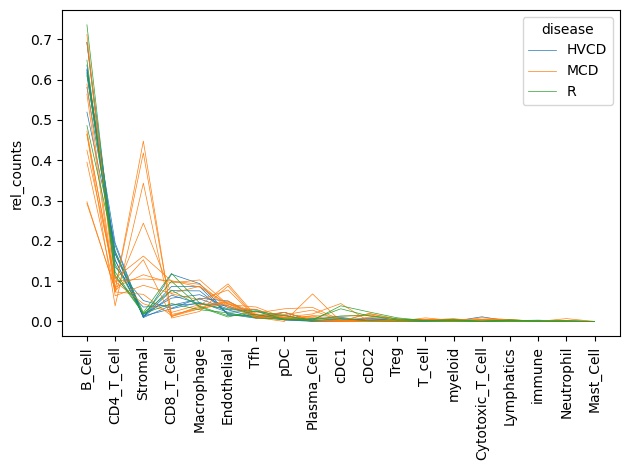

In [88]:
p = sns.lineplot(data=avg_df, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x=cts,
             y='rel_counts',
             hue='disease',
                units='name',
                estimator=None,
                lw=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
p
plt.savefig('outs/mantle200_celltypes_v1.pdf')

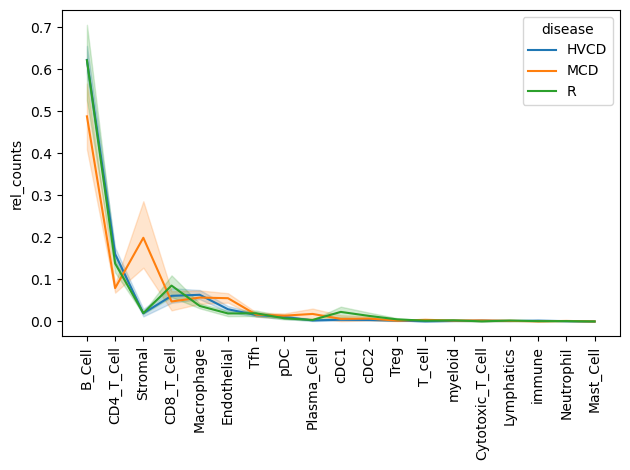

In [89]:
p = sns.lineplot(data=avg_df, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x=cts,
             y='rel_counts',
             hue='disease')
plt.xticks(rotation=90)
plt.tight_layout()
p
plt.savefig('outs/mantle200_celltypes_v2.pdf')

# Adding the MaxFuse stroma subtypes

In [3]:
# meta = pd.read_csv("allmeta_germ_contour.csv", index_col=0)
meta = pd.read_csv("allmeta_germ_contour100.csv", index_col=0)
meta.shape

(3895114, 27)

In [4]:
codex.obs = meta

In [5]:
# if starting from scratch...
codex.obs['fuse_pheno'] = codex.obs.new_pheno.astype(str)
for full_r in tqdm(codex.obs.region.unique()):
    # adata = codex[codex.obs.region == full_r,:].copy()
    fuse_dat = ad.read_h5ad("../maxfuse/maxfuse_out/"+full_r+"fuse_anno.h5ad")
    fuse_dat.obs_names = ["_".join([bc,full_r]) for bc in fuse_dat.obs_names.tolist()]
    # adata = adata[fuse_dat.obs_names,:]
    codex.obs.loc[fuse_dat.obs_names, "fuse_pheno"] = fuse_dat.obs.fuse_pheno

100%|██████████| 24/24 [00:24<00:00,  1.00s/it]


In [6]:
# all_fl_df = pd.concat(all_fl_dat, axis=0, ignore_index=True)
# with open("mantle_df_maxfuse.pk","wb") as f:
#     pk.dump(all_fl_df, f)
# codex.obs.to_csv("allmeta_MaxFuse_germ_contour.csv")
codex.obs.fuse_pheno.loc[codex.obs.follicle_level > 0].value_counts()

fuse_pheno
B_Cell                                 586582
CD4_T_Cell                             174866
CD8_T_Cell                              77408
Macrophage                              67202
Fibroblastic stromal cell, type 1       37768
FDC                                     23525
Plasma_Cell                             20776
pDC                                     18281
Endothelial                             16240
Tfh                                     15425
Stromal                                 15087
Fibroblastic stromal cell, type 2       13368
cDC1                                    11350
cDC2                                     8956
lymphatic endothelial cell               7589
ACTA2+ perivascular reticular cells      7470
blood endothelial cell                   6371
B_Cell_germ                              4187
T_cell                                   4160
Treg                                     3068
Cytotoxic_T_Cell                         2971
myeloid                

In [7]:
codex.obs.to_csv("allmeta_germ_contour100_rep3.csv")

# Visualization with MaxFuse labels


In [4]:
# meta = codex.obs.copy()
# or, just load it...
meta = pd.read_csv("allmeta_germ_contour100_rep3.csv")
meta_foll = meta.loc[meta.follicle_level != -1,:]
level_sizes = meta_foll.groupby(["region", "follicle", "follicle_level"]).size()
level_sizes.name = "absolute_size"
max_scale = np.log(meta_foll.follicle_area).max()

In [10]:
level_sizes

region      follicle  follicle_level
HVCD1_reg1  1         8                 531
                      9                 961
                      10                531
            2         5                 237
                      6                 597
                                       ... 
R2_reg1     16        9                 422
                      10                476
            17        8                 150
                      9                 313
                      10                340
Name: absolute_size, Length: 1613, dtype: int64

## All cell types (diversity)

In [11]:
meta = meta_foll.copy()
meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
       'fuse_pheno']]
pdata = meta.groupby(["region", "follicle", "follicle_level","fuse_pheno"], as_index=True).agg(
    **{
        "size": pd.NamedAgg(column="new_pheno", aggfunc="size"),
        "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
    })
pdata = pdata.join(level_sizes)
pdata['rel_size'] = pdata['size']/pdata['absolute_size']
pdata2 = pdata.groupby(["region", "follicle_level","fuse_pheno"], as_index=True)[["rel_size"]].mean()
pdata2.reset_index(inplace=True)
pdata2[["donor","reg"]] = pdata2[["region"]].apply(lambda x: x[0].split("_"), axis=1, result_type="expand")
pdata2['disease'] = pdata2[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)

In [20]:
# pk = pdata2.loc[(pdata2.region=="HVCD1_reg1") & (pdata2.follicle_level==0),:].rel_size.to_numpy()
pk = pdata2.loc[(pdata2.region=="R1_reg1") & (pdata2.follicle_level==0),:].rel_size.to_numpy()
sci.stats.entropy(pk)

1.815132823015233

In [33]:
foll_entropy = pdata2.groupby(["region","follicle_level"]).apply(lambda x: sci.stats.entropy(x['rel_size'].to_numpy()))
foll_entropy.name = "entropy"
foll_entropy_df = foll_entropy.reset_index()
foll_entropy_df['disease'] = foll_entropy_df[["region"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)
foll_entropy_df.head()

region  follicle_level   entropy disease
0  HVCD1_reg1               0  1.334377    HVCD
1  HVCD1_reg1               1  1.253040    HVCD
2  HVCD1_reg1               2  1.296725    HVCD
3  HVCD1_reg1               3  1.278544    HVCD
4  HVCD1_reg1               4  1.155128    HVCD

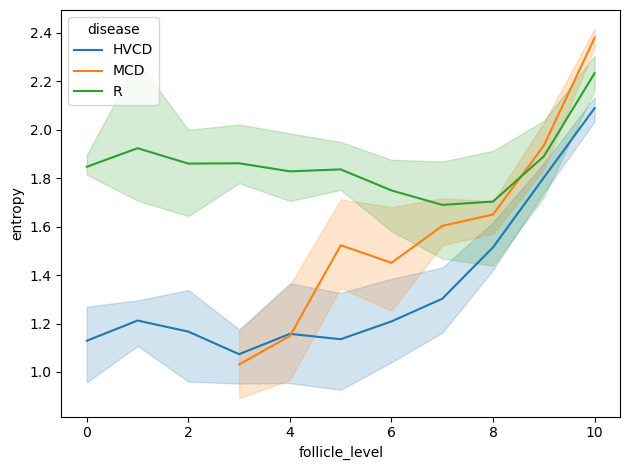

In [35]:
p = sns.lineplot(data=foll_entropy_df, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x='follicle_level',
             y='entropy',
             hue='disease')
# plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('outs/all_folls_entropy.pdf')

In [32]:
foll_entropy_df

region  follicle_level   entropy
0    HVCD1_reg1               0  1.334377
1    HVCD1_reg1               1  1.253040
2    HVCD1_reg1               2  1.296725
3    HVCD1_reg1               3  1.278544
4    HVCD1_reg1               4  1.155128
..          ...             ...       ...
182     R2_reg1               6  1.501791
183     R2_reg1               7  1.380812
184     R2_reg1               8  1.335508
185     R2_reg1               9  1.642218
186     R2_reg1              10  2.176287

[187 rows x 3 columns]

In [24]:
pdata2.head()

region  follicle_level                           fuse_pheno  rel_size  \
0  HVCD1_reg1               0  ACTA2+ perivascular reticular cells  0.001464   
1  HVCD1_reg1               0                               B_Cell  0.630538   
2  HVCD1_reg1               0                           CD4_T_Cell  0.196527   
3  HVCD1_reg1               0                           CD8_T_Cell  0.081878   
4  HVCD1_reg1               0                     Cytotoxic_T_Cell  0.004797   

   donor   reg disease  
0  HVCD1  reg1    HVCD  
1  HVCD1  reg1    HVCD  
2  HVCD1  reg1    HVCD  
3  HVCD1  reg1    HVCD  
4  HVCD1  reg1    HVCD

## Per cell type

In [8]:
meta.follicle_level.value_counts()

follicle_level
-1     2749688
 9      277689
 10     276330
 8      198987
 7      133473
 6       88200
 5       60125
 4       40506
 3       26967
 2       17272
 0       14526
 1       11351
Name: count, dtype: int64

In [ ]:
# with open("mantle_df_maxfuse.pk","rb") as f:
#     all_fl_df = pk.load(f)
# all_fl_df.head()

In [21]:
meta_foll.fuse_pheno.value_counts()

fuse_pheno
B_Cell                                 596029
CD4_T_Cell                             176346
CD8_T_Cell                              78059
Macrophage                              67598
Fibroblastic stromal cell, type 1       38277
FDC                                     23927
Plasma_Cell                             20885
pDC                                     18334
Endothelial                             16313
Tfh                                     15767
Stromal                                 15279
Fibroblastic stromal cell, type 2       13534
cDC1                                    11546
cDC2                                     9086
lymphatic endothelial cell               7641
ACTA2+ perivascular reticular cells      7592
blood endothelial cell                   6381
B_Cell_germ                              4206
T_cell                                   4187
Treg                                     3115
Cytotoxic_T_Cell                         3005
myeloid                

In [20]:
# meta_foll.fuse_pheno.loc[meta_foll.fuse_pheno == "]

Unnamed: 0     orig.ident  nCount_originalexp  \
77749_MCD1_reg1     78670.0  SeuratProject           -0.515665   
94194_MCD1_reg1     95226.0  SeuratProject           -0.060197   
94238_MCD1_reg1     95270.0  SeuratProject           -1.502454   
94254_MCD1_reg1     95286.0  SeuratProject            3.399273   
94301_MCD1_reg1     95333.0  SeuratProject           -0.626928   

                 nFeature_originalexp  Reg  Tile.Row  Tile.Col  Tile.Z  \
77749_MCD1_reg1                    18    0         1         1       0   
94194_MCD1_reg1                    19    0         1         1       0   
94238_MCD1_reg1                    13    0         1         1       0   
94254_MCD1_reg1                    23    0         1         1       0   
94301_MCD1_reg1                    13    0         1         1       0   

                   In.Tile.Y    In.Tile.X  ...  cell_type_pred_knn  \
77749_MCD1_reg1  3989.463950  1051.811912  ...          CD4_T_Cell   
94194_MCD1_reg1  4582.195513   725.250000  ...                 pDC   
94238_MCD1_reg1  4719.090047   777.668246  ...          CD4_T_Cell   
94254_MCD1_reg1  4455.543624   799.355705  ...              B_Cell   
94301_MCD1_reg1  4640.378995   709.570776  ...         Endothelial   

                 cell_type_pred_knn_prob    motif  index_info    new_pheno  \
77749_MCD1_reg1                      0.8  Motif_1       77749   CD4_T_Cell   
94194_MCD1_reg1                      1.0  Motif_7       94194          pDC   
94238_MCD1_reg1                      1.0  Motif_0       94238   CD4_T_Cell   
94254_MCD1_reg1                      0.6  Motif_0       94254       B_Cell   
94301_MCD1_reg1                      1.0  Motif_0       94301  Endothelial   

                    region  follicle follicle_level  follicle_area  \
77749_MCD1_reg1  MCD1_reg1         1             10  107878.093233   
94194_MCD1_reg1  MCD1_reg1         3             10  420586.127995   
94238_MCD1_reg1  MCD1_reg1         3             10  420586.127995   
94254_MCD1_reg1  MCD1_reg1         3             10  420586.127995   
94301_MCD1_reg1  MCD1_reg1         3             10  420586.127995   

                       fuse_pheno  
77749_MCD1_reg1        CD4_T_Cell  
94194_MCD1_reg1               pDC  
94238_MCD1_reg1        CD4_T_Cell  
94254_MCD1_reg1            B_Cell  
94301_MCD1_reg1  Cytotoxic_T_Cell  

[5 rows x 27 columns]

### Test cell
Stromal

In [102]:
meta = meta.loc[(meta.fuse_pheno == "Stromal") & (meta.follicle_level != -1),:]
meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
       'fuse_pheno']]
meta.head()

Empty DataFrame
Columns: [new_pheno, region, follicle, follicle_level, follicle_area, fuse_pheno]
Index: []

In [126]:

pdata = meta.groupby(["region", "follicle", "follicle_level"], as_index=True).agg(
    **{
        "size": pd.NamedAgg(column="fuse_pheno", aggfunc="size"),
        "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
    })
# pdata["rel_size"] = pdata.groupby(['region', 'follicle'])[['size']].apply(lambda x: x/x.sum())["size"].values
pdata = pdata.join(level_sizes)
pdata['rel_size'] = pdata['size']/pdata['absolute_size']

In [10]:
# pdata.set_index(["region","follicle"])

pdata2 = pdata.groupby(["region", "follicle_level"], as_index=True)[["rel_size"]].mean()
pdata2.reset_index(inplace=True)
pdata2[["donor","reg"]] = pdata2[["region"]].apply(lambda x: x[0].split("_"), axis=1, result_type="expand")
pdata2['disease'] = pdata2[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)
pdata2

NameError: name 'pdata' is not defined

In [11]:
ct= "CD4_T_Cell"
meta = meta_foll.copy()
meta = meta.loc[meta.new_pheno == ct,:]
meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
       'fuse_pheno']]
pdata = meta.groupby(["region", "follicle", "follicle_level"], as_index=True).agg(
    **{
        "size": pd.NamedAgg(column="new_pheno", aggfunc="size"),
        "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
    })
pdata = pdata.join(level_sizes)
pdata['rel_size'] = pdata['size']/pdata['absolute_size']
pdata2 = pdata.groupby(["region", "follicle_level"], as_index=True)[["rel_size"]].mean()
pdata2.reset_index(inplace=True)
pdata2[["donor","reg"]] = pdata2[["region"]].apply(lambda x: x[0].split("_"), axis=1, result_type="expand")
pdata2['disease'] = pdata2[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)

In [12]:
donor_cols = ['#9999cc','#666699','#ff9933','#ff6633','#cc3333' ,'#66cc66', '#339933']
donor_cmap = {pdata2.donor.unique()[i]:donor_cols[i] for i in range(pdata2.donor.nunique())}
donor_cmap

{'HVCD1': '#9999cc',
 'HVCD2': '#666699',
 'MCD1': '#ff9933',
 'MCD3': '#ff6633',
 'MCD4': '#cc3333',
 'R1': '#66cc66',
 'R2': '#339933'}

In [13]:
pdata["donor"] = pdata.index.map(lambda x: x[0].split("_")[0])
pdata['disease'] = pdata[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)
pdata.reset_index(inplace=True)

/tmp/ipykernel_2518467/976609702.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=pdata_d.scaled_area,


NameError: name 'p' is not defined

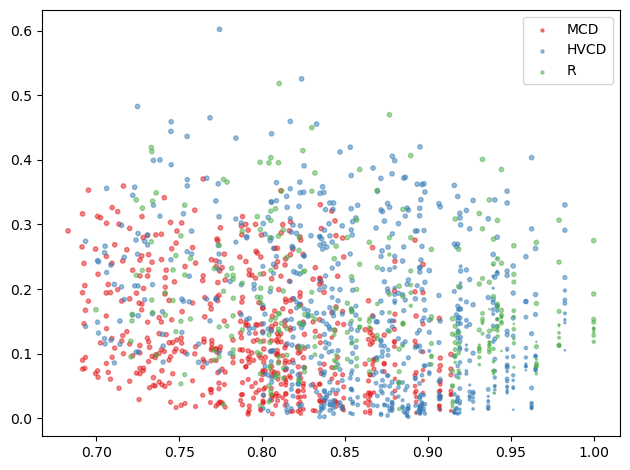

In [14]:
# cmap = mpl.colormaps["Set1"]
# colordict={pdata.disease.unique()[i]:cmap(i) for i in range(len(pdata.disease.unique()))}
for d in pdata.donor.unique():
    pdata_d = pdata.loc[pdata.donor==d,:]
    plt.scatter(x=pdata_d.scaled_area,
                y=pdata_d.rel_size,
                c=donor_cmap[d],
                s=pdata_d.follicle_level,
                alpha=0.5,
               label=d)
# plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()


<Axes: xlabel='follicle_level', ylabel='rel_size'>

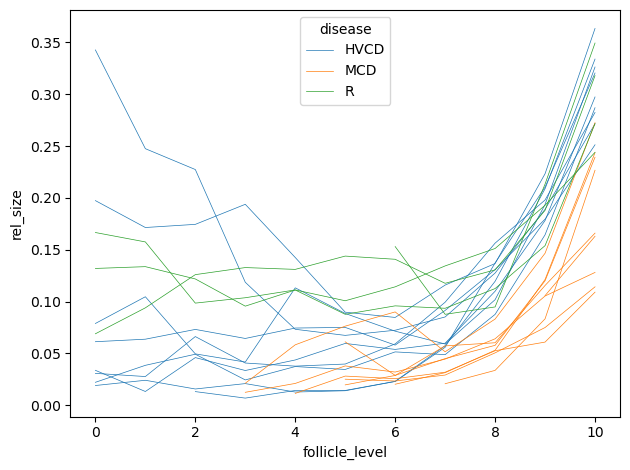

In [14]:
p = sns.lineplot(data=pdata2, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x='follicle_level',
             y='rel_size',
             hue='disease',
                 # c=donor_cmap,
                units='region',
                estimator=None,
                lw=0.5)
# plt.xticks(rotation=90)
plt.tight_layout()
p
# plt.savefig('outs/mantle200_MaxFuse_celltypes_v1.pdf')

In [33]:
p
plt.show()

<Axes: xlabel='follicle_level', ylabel='rel_size'>

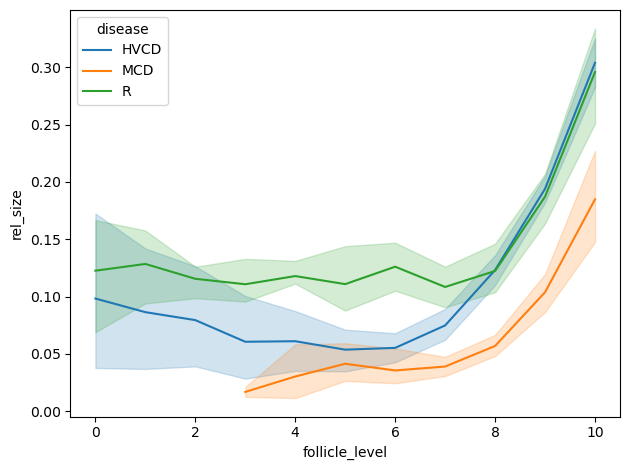

In [15]:
p = sns.lineplot(data=pdata2, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x='follicle_level',
             y='rel_size',
             hue='disease')
# plt.xticks(rotation=90)
plt.tight_layout()
p
# plt.savefig('outs/mantle200_MaxFuse_celltypes_v2.pdf')

## all cells

or top 24 by abundance

In [16]:
font = {"size": 8}
mpl.rc('font', **font)

In [19]:
codex.obs.fuse_pheno.value_counts()

fuse_pheno
B_Cell                                 993653
CD4_T_Cell                             855696
Macrophage                             419503
Plasma_Cell                            404130
CD8_T_Cell                             389830
pDC                                    112332
Fibroblastic stromal cell, type 1      102669
Endothelial                             98715
Fibroblastic stromal cell, type 2       70757
lymphatic endothelial cell              53860
Stromal                                 49350
cDC2                                    44875
blood endothelial cell                  42522
cDC1                                    35124
Tfh                                     30480
FDC                                     30398
T_cell                                  30115
ACTA2+ perivascular reticular cells     26384
Memory or effector T cells              19672
Cytotoxic_T_Cell                        18559
myeloid                                 14504
immune                 

In [26]:
# plot_cells = codex.obs.fuse_pheno.loc[codex.obs.follicle_level != -1].value_counts()
plot_cells = meta_foll.fuse_pheno.value_counts()
plot_cells.index[:20]

Index(['B_Cell', 'CD4_T_Cell', 'CD8_T_Cell', 'Macrophage',
       'Fibroblastic stromal cell, type 1', 'FDC', 'blood endothelial cell',
       'Plasma_Cell', 'pDC', 'Tfh', 'Stromal',
       'Fibroblastic stromal cell, type 2', 'cDC1', 'cDC2',
       'lymphatic endothelial cell', 'ACTA2+ perivascular reticular cells',
       'B_Cell_germ', 'T_cell', 'Treg', 'Cytotoxic_T_Cell'],
      dtype='object', name='fuse_pheno')

In [23]:
# renaming a few cells
meta_foll.fuse_pheno.loc[meta_foll.fuse_pheno=="Endothelial"] = 'blood endothelial cell'

In [24]:
len(meta_foll.fuse_pheno.unique())

28

In [18]:
handles, labels = p.get_legend_handles_labels()


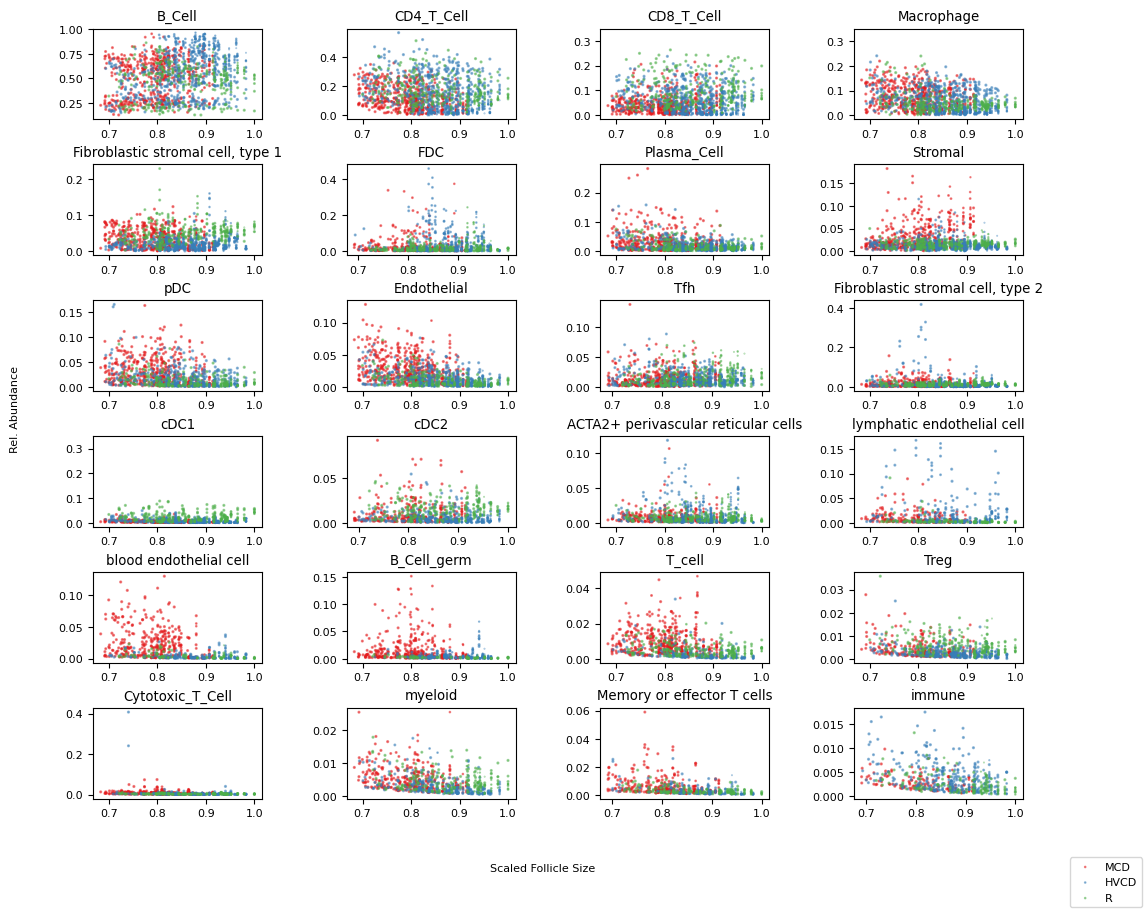

In [19]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(12,10))
ax = ax.ravel()

for i in range(24):
    ct = plot_cells.index[i]
    meta = codex.obs.copy()
    meta = meta.loc[(meta.fuse_pheno == ct) & (meta.follicle_level != -1),:]
    meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
           'fuse_pheno']]
    pdata = meta.groupby(["region", "follicle", "follicle_level"], as_index=True).agg(
        **{
            "size": pd.NamedAgg(column="fuse_pheno", aggfunc="size"),
            "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
        })
    pdata = pdata.join(level_sizes)
    pdata['rel_size'] = pdata['size']/pdata['absolute_size']
    pdata["donor"] = pdata.index.map(lambda x: x[0].split("_")[0])
    pdata['disease'] = pdata[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)
    pdata.reset_index(inplace=True)

    cmap = mpl.colormaps["Set1"]
    colordict={pdata.disease.unique()[i]:cmap(i) for i in range(len(pdata.disease.unique()))}
    for d in pdata.disease.unique():
        pdata_d = pdata.loc[pdata.disease==d,:]
        ax[i].scatter(x=pdata_d.scaled_area,
                    y=pdata_d.rel_size,
                    c=pdata_d.disease.map(colordict),
                    s=pdata_d.follicle_level/6,
                    alpha=0.5,
                   label=d)


    ax[i].set_title(ct)
    ax[i].xaxis.label.set_visible(False)
    ax[i].yaxis.label.set_visible(False)
    # plt.xticks(rotation=90)

handles, labels = ax[0].get_legend_handles_labels()
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
# fig.legend(labels, loc='lower right', bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)
fig.legend(handles, labels, loc='lower right')
fig.text(0.5, 0.04, 'Scaled Follicle Size', ha='center', va='center')
fig.text(0.06, 0.5, 'Rel. Abundance', ha='center', va='center', rotation='vertical')
# plt.tight_layout()
# plt.savefig('outs/contour100/scatter_MaxFuseCellTypes.pdf')

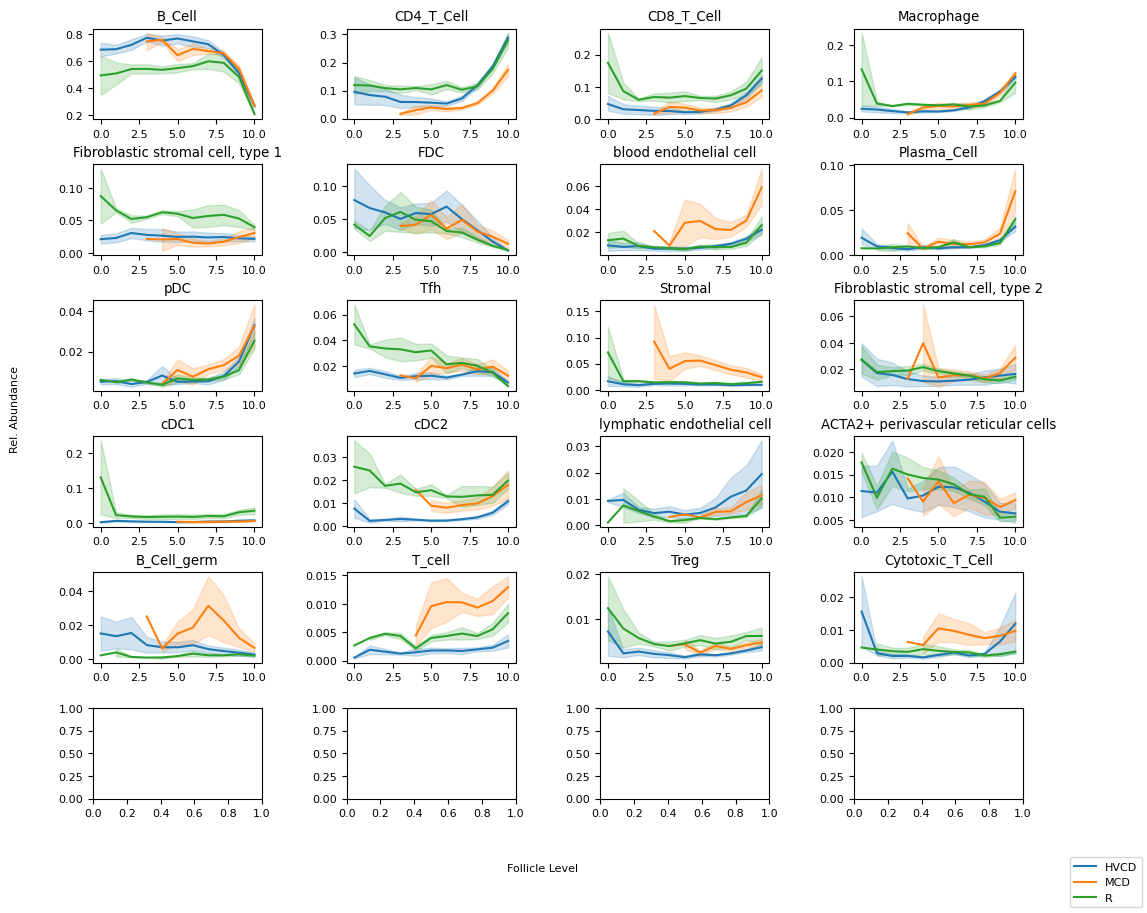

In [27]:
# !!Reset the legend information (like above)!!
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(12,10))
ax = ax.ravel()

for i in range(20):
    ct = plot_cells.index[i]
    meta = meta_foll.copy()
    meta = meta.loc[meta.fuse_pheno == ct,:]
    meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
           'fuse_pheno']]
    pdata = meta.groupby(["region", "follicle", "follicle_level"], as_index=True).agg(
        **{
            "size": pd.NamedAgg(column="fuse_pheno", aggfunc="size"),
            "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
        })
    pdata = pdata.join(level_sizes)
    pdata['rel_size'] = pdata['size']/pdata['absolute_size']
    pdata2 = pdata.groupby(["region", "follicle_level"], as_index=True)[["rel_size"]].mean()
    pdata2.reset_index(inplace=True)
    pdata2[["donor","reg"]] = pdata2[["region"]].apply(lambda x: x[0].split("_"), axis=1, result_type="expand")
    pdata2['disease'] = pdata2[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)

    sns.lineplot(data=pdata2, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x='follicle_level',
             y='rel_size',
             hue='disease', 
                 errorbar=('ci',80),
                 ax=ax[i],
                 legend=False
                )
    ax[i].set_title(ct)
    ax[i].xaxis.label.set_visible(False)
    ax[i].yaxis.label.set_visible(False)
    # plt.xticks(rotation=90)

handles, labels = p.get_legend_handles_labels()
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
# fig.legend(labels, loc='lower right', bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)
fig.legend(handles, labels, loc='lower right')
fig.text(0.5, 0.04, 'Follicle Level', ha='center', va='center')
fig.text(0.06, 0.5, 'Rel. Abundance', ha='center', va='center', rotation='vertical')
# plt.tight_layout()
plt.savefig('outs/contour100/lines_disease_MaxFuseCellTypes_v3.pdf')

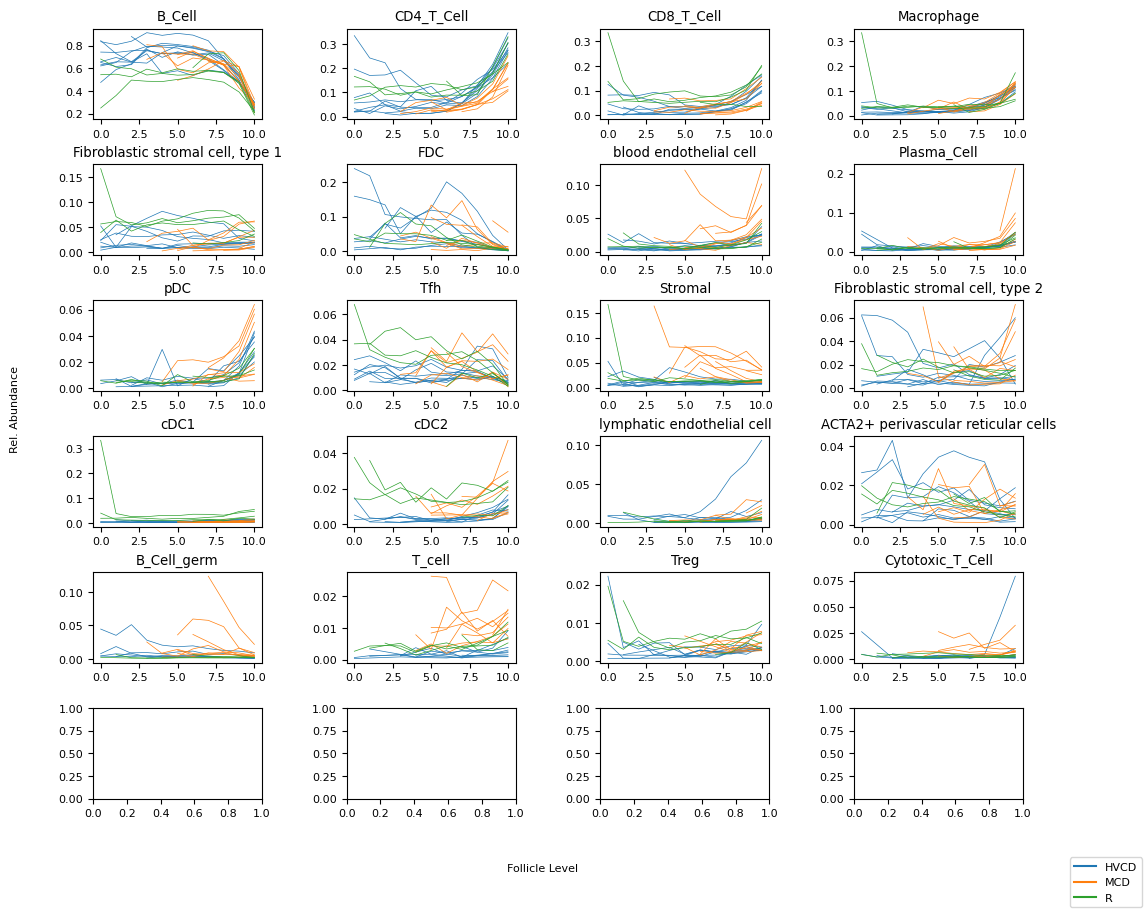

In [28]:
# !!run one example to get the legend information (like above)!!
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(12,10))
ax = ax.ravel()

for i in range(20):
    ct = plot_cells.index[i]
    meta = meta_foll.copy()
    meta = meta.loc[meta.fuse_pheno == ct,:]
    meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
           'fuse_pheno']]
    pdata = meta.groupby(["region", "follicle", "follicle_level"], as_index=True).agg(
        **{
            "size": pd.NamedAgg(column="fuse_pheno", aggfunc="size"),
            "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
        })
    pdata = pdata.join(level_sizes)
    pdata['rel_size'] = pdata['size']/pdata['absolute_size']
    pdata2 = pdata.groupby(["region", "follicle_level"], as_index=True)[["rel_size"]].mean()
    pdata2.reset_index(inplace=True)
    pdata2[["donor","reg"]] = pdata2[["region"]].apply(lambda x: x[0].split("_"), axis=1, result_type="expand")
    pdata2['disease'] = pdata2[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)

    sns.lineplot(data=pdata2, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x='follicle_level',
             y='rel_size',
             hue='disease',
                units='region',
                estimator=None,
                lw=0.5,
                 ax=ax[i],
                 legend=False
                )
    ax[i].set_title(ct)
    ax[i].xaxis.label.set_visible(False)
    ax[i].yaxis.label.set_visible(False)
    # plt.xticks(rotation=90)

handles, labels = p.get_legend_handles_labels()
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
# fig.legend(labels, loc='lower right', bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)
fig.legend(handles, labels, loc='lower right')
fig.text(0.5, 0.04, 'Follicle Level', ha='center', va='center')
fig.text(0.06, 0.5, 'Rel. Abundance', ha='center', va='center', rotation='vertical')
# plt.tight_layout()
plt.savefig('outs/contour100/lines_donor_MaxFuseCellTypes_v3.pdf')

### Split up follicle size

In [29]:
# meta = codex.obs.loc[codex.obs.follicle_level != -1,:]
size_quants = meta_foll.follicle_area.quantile([0.25, 0.50])

In [16]:
size_quants.iloc[0]

857807.708389456

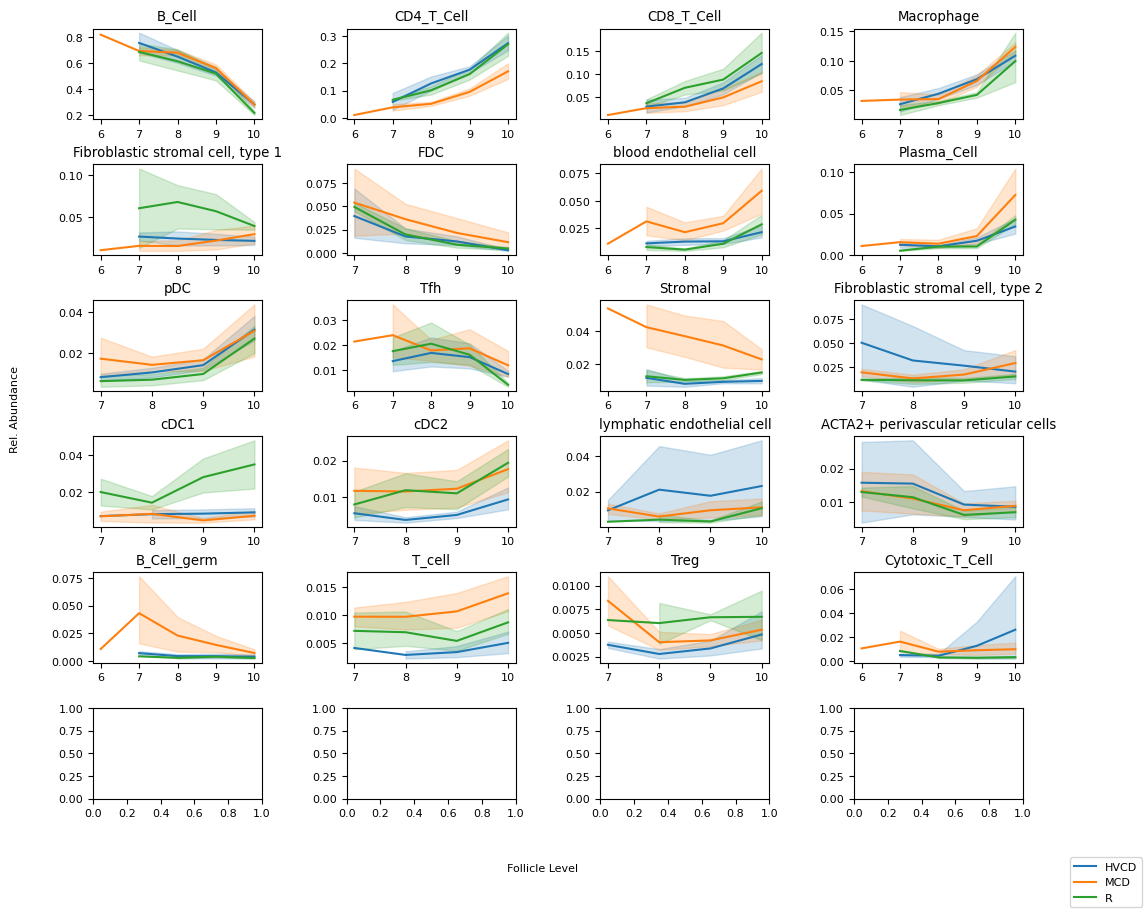

In [30]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(12,10))
ax = ax.ravel()

for i in range(20):
    ct = plot_cells.index[i]
    meta = meta_foll.copy()
    meta = meta.loc[(meta.fuse_pheno == ct) & (meta.follicle_area < size_quants.iloc[0]+1),:]
    meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
           'fuse_pheno']]
    pdata = meta.groupby(["region", "follicle", "follicle_level"], as_index=True).agg(
        **{
            "size": pd.NamedAgg(column="fuse_pheno", aggfunc="size"),
            "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
        })
    pdata = pdata.join(level_sizes)
    pdata['rel_size'] = pdata['size']/pdata['absolute_size']
    pdata2 = pdata.groupby(["region", "follicle_level"], as_index=True)[["rel_size"]].mean()
    pdata2.reset_index(inplace=True)
    pdata2[["donor","reg"]] = pdata2[["region"]].apply(lambda x: x[0].split("_"), axis=1, result_type="expand")
    pdata2['disease'] = pdata2[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)

    # sns.lineplot(data=pdata2, 
    #          # x=avg_df.index.get_level_values('cell_type'),
    #              x='follicle_level',
    #          y='rel_size',
    #          hue='disease',
    #             units='region',
    #             estimator=None,
    #             lw=0.5,
    #              ax=ax[i],
    #              legend=False
    #             )
    sns.lineplot(data=pdata2, 
         # x=avg_df.index.get_level_values('cell_type'),
             x='follicle_level',
         y='rel_size',
         hue='disease', 
                 errorbar=('ci',90),
             ax=ax[i],
             legend=False
            )
    ax[i].set_title(ct)
    ax[i].xaxis.label.set_visible(False)
    ax[i].yaxis.label.set_visible(False)
    # plt.xticks(rotation=90)

handles, labels = p.get_legend_handles_labels()
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
# fig.legend(labels, loc='lower right', bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)
fig.legend(handles, labels, loc='lower right')
fig.text(0.5, 0.04, 'Follicle Level', ha='center', va='center')
fig.text(0.06, 0.5, 'Rel. Abundance', ha='center', va='center', rotation='vertical')
# plt.tight_layout()
plt.savefig('outs/contour100/lines_disease_smallFoll_MaxFuseCellTypes_v3.pdf')

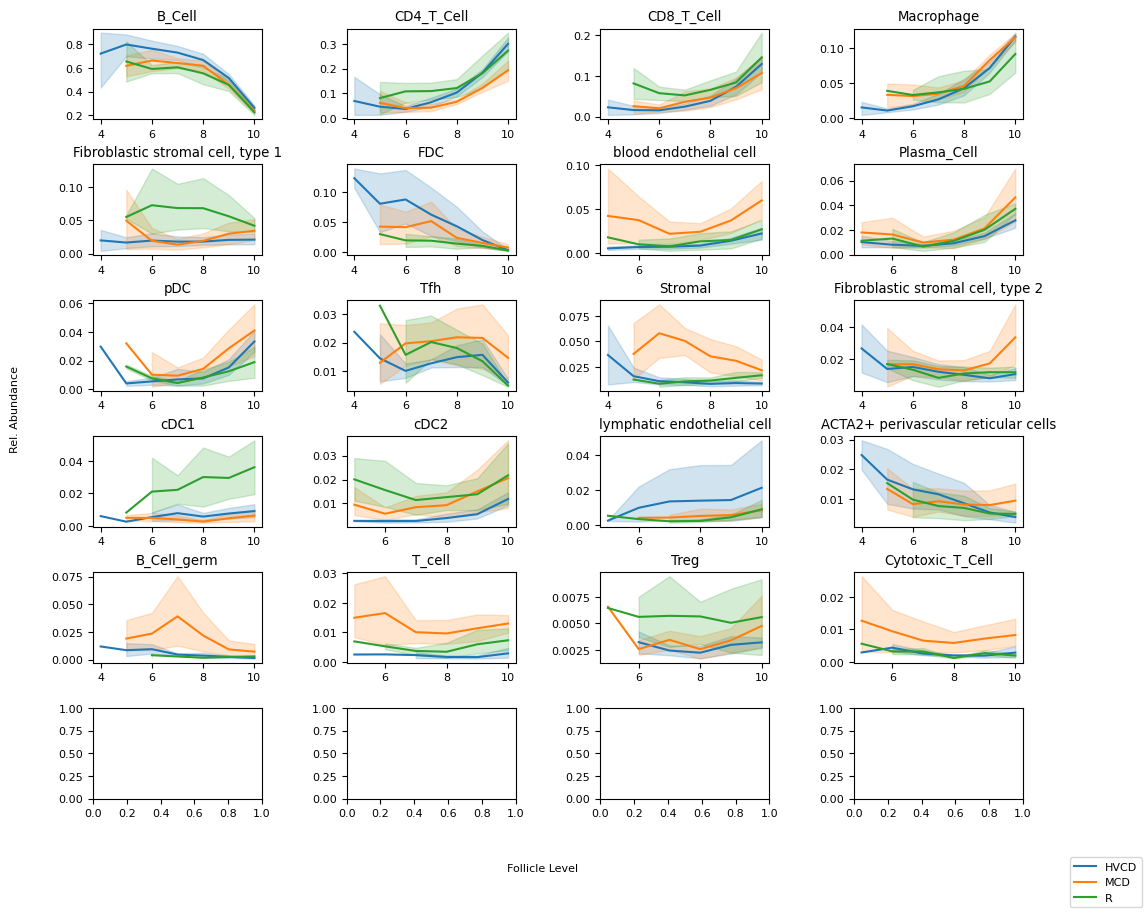

In [31]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(12,10))
ax = ax.ravel()

for i in range(20):
    ct = plot_cells.index[i]
    meta = meta_foll.copy()
    meta = meta.loc[(meta.fuse_pheno == ct) & (meta.follicle_area > size_quants.iloc[0]+1) & (meta.follicle_area < size_quants.iloc[1]+1),:]
    meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
           'fuse_pheno']]
    pdata = meta.groupby(["region", "follicle", "follicle_level"], as_index=True).agg(
        **{
            "size": pd.NamedAgg(column="fuse_pheno", aggfunc="size"),
            "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
        })
    pdata = pdata.join(level_sizes)
    pdata['rel_size'] = pdata['size']/pdata['absolute_size']
    pdata2 = pdata.groupby(["region", "follicle_level"], as_index=True)[["rel_size"]].mean()
    pdata2.reset_index(inplace=True)
    pdata2[["donor","reg"]] = pdata2[["region"]].apply(lambda x: x[0].split("_"), axis=1, result_type="expand")
    pdata2['disease'] = pdata2[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)

    # sns.lineplot(data=pdata2, 
    #          # x=avg_df.index.get_level_values('cell_type'),
    #              x='follicle_level',
    #          y='rel_size',
    #          hue='disease',
    #             units='region',
    #             estimator=None,
    #             lw=0.5,
    #              ax=ax[i],
    #              legend=False
    #             )
    sns.lineplot(data=pdata2, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x='follicle_level',
             y='rel_size',
             hue='disease', 
                 ax=ax[i],
                 legend=False
                )
    ax[i].set_title(ct)
    ax[i].xaxis.label.set_visible(False)
    ax[i].yaxis.label.set_visible(False)
    # plt.xticks(rotation=90)

handles, labels = p.get_legend_handles_labels()
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
# fig.legend(labels, loc='lower right', bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)
fig.legend(handles, labels, loc='lower right')
fig.text(0.5, 0.04, 'Follicle Level', ha='center', va='center')
fig.text(0.06, 0.5, 'Rel. Abundance', ha='center', va='center', rotation='vertical')
# plt.tight_layout()
plt.savefig('outs/contour100/lines_disease_mediumFoll_MaxFuseCellTypes_v3.pdf')

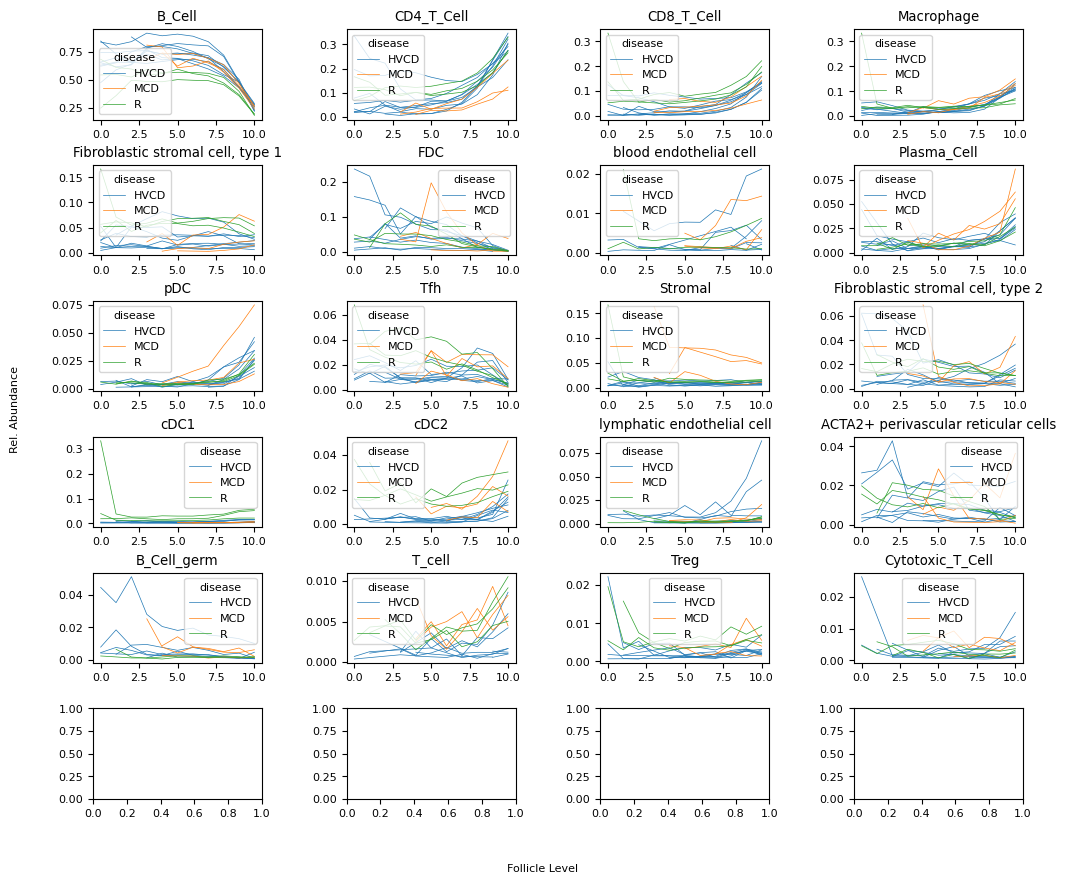

In [32]:
fig, ax = plt.subplots(nrows=6, ncols=4, figsize=(12,10))
ax = ax.ravel()

for i in range(20):
    ct = plot_cells.index[i]
    meta = codex.obs.copy()
    meta = meta.loc[(meta.fuse_pheno == ct) & (meta.follicle_level != -1) & (meta.follicle_area > size_quants.iloc[1]+1),:]
    meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
           'fuse_pheno']]
    pdata = meta.groupby(["region", "follicle", "follicle_level"], as_index=True).agg(
        **{
            "size": pd.NamedAgg(column="fuse_pheno", aggfunc="size"),
            "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
        })
    pdata = pdata.join(level_sizes)
    pdata['rel_size'] = pdata['size']/pdata['absolute_size']
    pdata2 = pdata.groupby(["region", "follicle_level"], as_index=True)[["rel_size"]].mean()
    pdata2.reset_index(inplace=True)
    pdata2[["donor","reg"]] = pdata2[["region"]].apply(lambda x: x[0].split("_"), axis=1, result_type="expand")
    pdata2['disease'] = pdata2[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)

    sns.lineplot(data=pdata2, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x='follicle_level',
             y='rel_size',
             hue='disease',
                units='region',
                estimator=None,
                lw=0.5,
                 ax=ax[i],
                 legend=True
                )
    # sns.lineplot(data=pdata2, 
    #          # x=avg_df.index.get_level_values('cell_type'),
    #              x='follicle_level',
    #          y='rel_size',
    #          hue='disease', 
    #              ax=ax[i],
    #              legend=False
    #             )
    ax[i].set_title(ct)
    ax[i].xaxis.label.set_visible(False)
    ax[i].yaxis.label.set_visible(False)
    ax[i].set_title(ct)
    ax[i].xaxis.label.set_visible(False)
    ax[i].yaxis.label.set_visible(False)
    # plt.xticks(rotation=90)

# handles, labels = p.get_legend_handles_labels()
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
# fig.legend(labels, loc='lower right', bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)
# fig.legend(handles, labels, loc='lower right')
fig.text(0.5, 0.04, 'Follicle Level', ha='center', va='center')
fig.text(0.06, 0.5, 'Rel. Abundance', ha='center', va='center', rotation='vertical')
# plt.tight_layout()
plt.savefig('outs/contour100/lines_disease_largeFoll_MaxFuseCellTypes_v3.pdf')

# Visualization with original labels

Hopefully the same plot axis labels will work. If not see above

In [55]:
plot_cells = codex.obs.new_pheno.loc[codex.obs.follicle_level != -1].value_counts()
plot_cells.index[:24]

Index(['B_Cell', 'CD4_T_Cell', 'CD8_T_Cell', 'Macrophage', 'Endothelial',
       'Stromal', 'pDC', 'Tfh', 'cDC1', 'cDC2', 'Plasma_Cell', 'myeloid',
       'Treg', 'Lymphatics', 'T_cell', 'immune', 'Neutrophil',
       'Cytotoxic_T_Cell', 'Mast_Cell'],
      dtype='object', name='new_pheno')

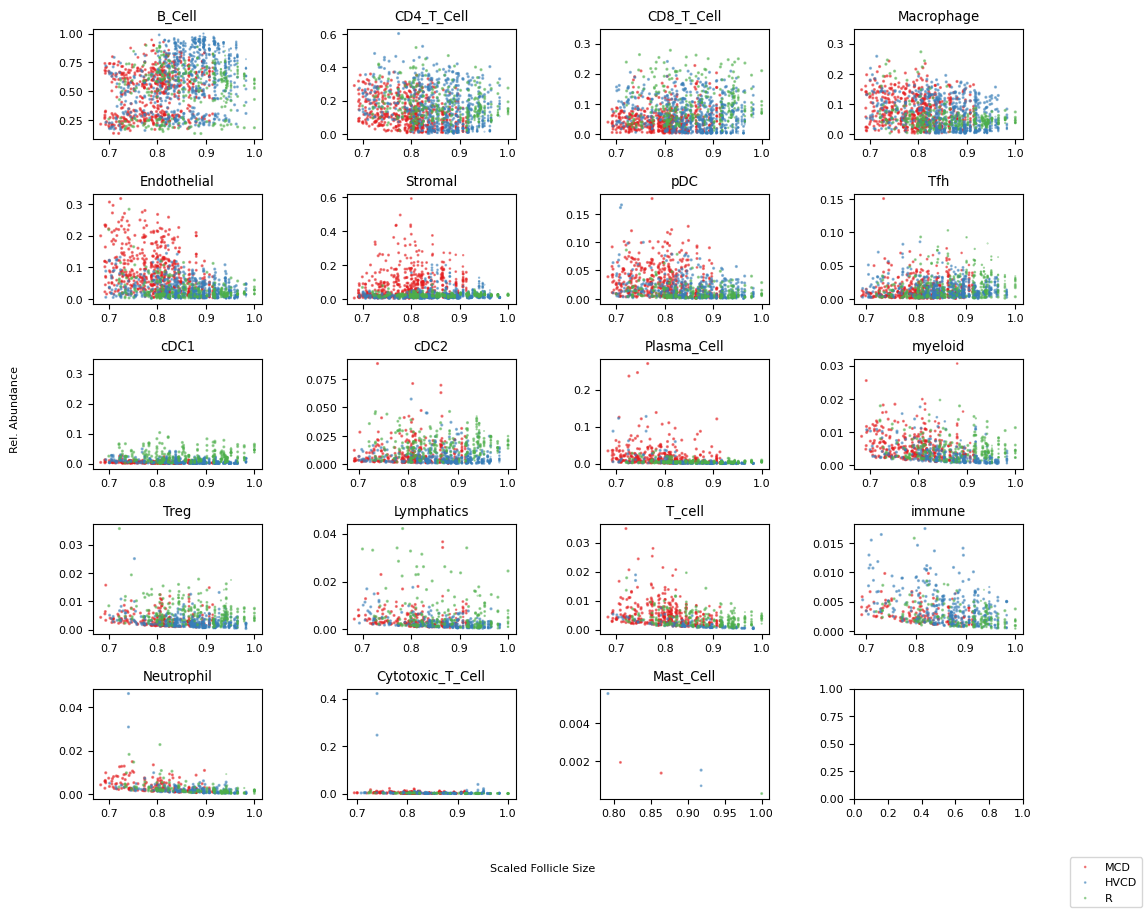

In [27]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(12,10))
ax = ax.ravel()

for i in range(19):
    ct = plot_cells.index[i]
    meta = codex.obs.copy()
    meta = meta.loc[(meta.new_pheno == ct) & (meta.follicle_level != -1),:]
    meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
           'fuse_pheno']]
    pdata = meta.groupby(["region", "follicle", "follicle_level"], as_index=True).agg(
        **{
            "size": pd.NamedAgg(column="new_pheno", aggfunc="size"),
            "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
        })
    pdata = pdata.join(level_sizes)
    pdata['rel_size'] = pdata['size']/pdata['absolute_size']
    pdata["donor"] = pdata.index.map(lambda x: x[0].split("_")[0])
    pdata['disease'] = pdata[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)
    pdata.reset_index(inplace=True)

    cmap = mpl.colormaps["Set1"]
    colordict={pdata.disease.unique()[i]:cmap(i) for i in range(len(pdata.disease.unique()))}
    for d in pdata.disease.unique():
        pdata_d = pdata.loc[pdata.disease==d,:]
        ax[i].scatter(x=pdata_d.scaled_area,
                    y=pdata_d.rel_size,
                    c=pdata_d.disease.map(colordict),
                    s=pdata_d.follicle_level/6,
                    alpha=0.5,
                   label=d)


    ax[i].set_title(ct)
    ax[i].xaxis.label.set_visible(False)
    ax[i].yaxis.label.set_visible(False)
    # plt.xticks(rotation=90)

handles, labels = ax[0].get_legend_handles_labels()
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
# fig.legend(labels, loc='lower right', bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)
fig.legend(handles, labels, loc='lower right')
fig.text(0.5, 0.04, 'Scaled Follicle Size', ha='center', va='center')
fig.text(0.06, 0.5, 'Rel. Abundance', ha='center', va='center', rotation='vertical')
# plt.tight_layout()
plt.savefig('outs/contour100/scatter_contour150_origCellTypes.pdf')

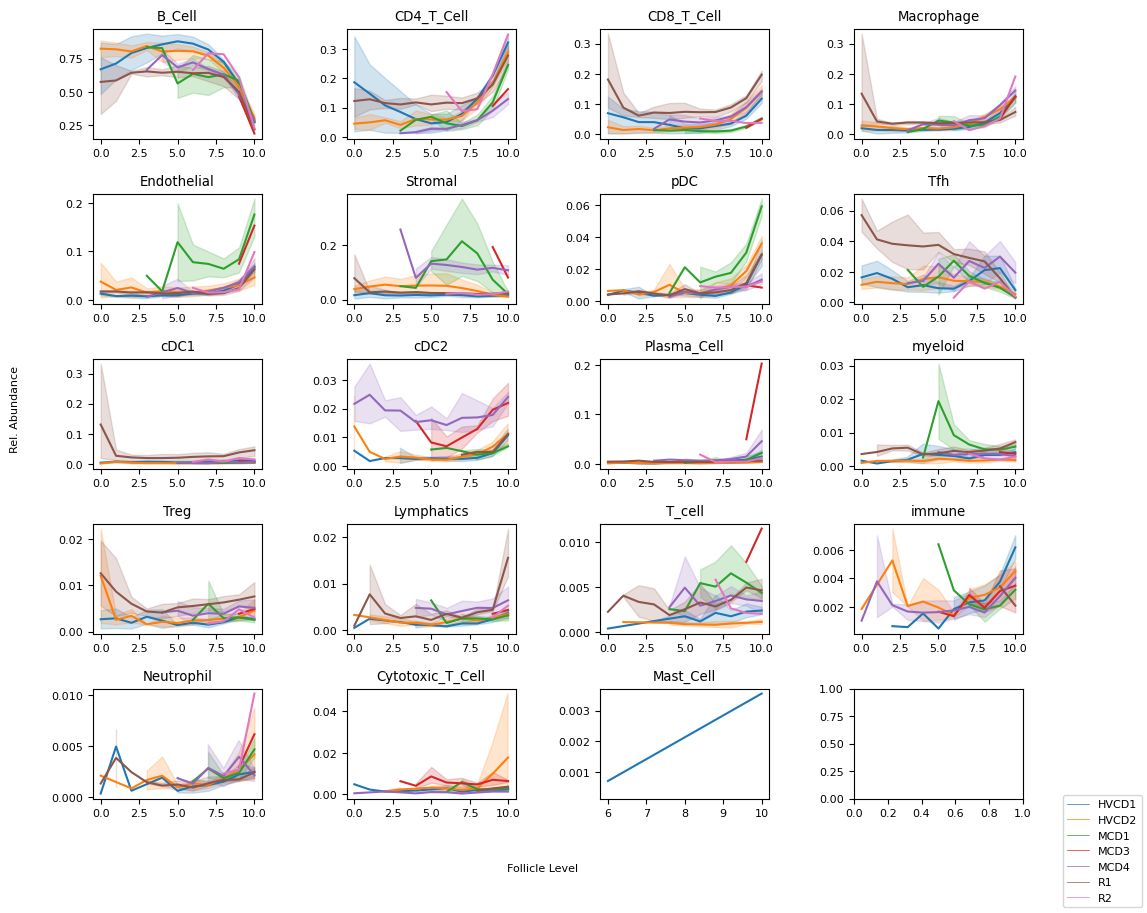

In [56]:
# !!run one example to get the legend information (like above)!!
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(12,10))
ax = ax.ravel()

for i in range(19):
    ct = plot_cells.index[i]
    meta = codex.obs.copy()
    meta = meta.loc[(meta.new_pheno == ct) & (meta.follicle_level != -1),:]
    meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
           'fuse_pheno']]
    pdata = meta.groupby(["region", "follicle", "follicle_level"], as_index=True).agg(
        **{
            "size": pd.NamedAgg(column="new_pheno", aggfunc="size"),
            "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
        })
    pdata = pdata.join(level_sizes)
    pdata['rel_size'] = pdata['size']/pdata['absolute_size']
    pdata2 = pdata.groupby(["region", "follicle_level"], as_index=True)[["rel_size"]].mean()
    pdata2.reset_index(inplace=True)
    pdata2[["donor","reg"]] = pdata2[["region"]].apply(lambda x: x[0].split("_"), axis=1, result_type="expand")
    pdata2['disease'] = pdata2[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)

    sns.lineplot(data=pdata2, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x='follicle_level',
             y='rel_size',
             hue='donor', 
                 ax=ax[i],
                 legend=False
                )
    ax[i].set_title(ct)
    ax[i].xaxis.label.set_visible(False)
    ax[i].yaxis.label.set_visible(False)
    # plt.xticks(rotation=90)

handles, labels = p.get_legend_handles_labels()
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
# fig.legend(labels, loc='lower right', bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)
fig.legend(handles, labels, loc='lower right')
fig.text(0.5, 0.04, 'Follicle Level', ha='center', va='center')
fig.text(0.06, 0.5, 'Rel. Abundance', ha='center', va='center', rotation='vertical')
# plt.tight_layout()
plt.savefig('outs/contour100/lines_donor_origCellTypes_v2.pdf')

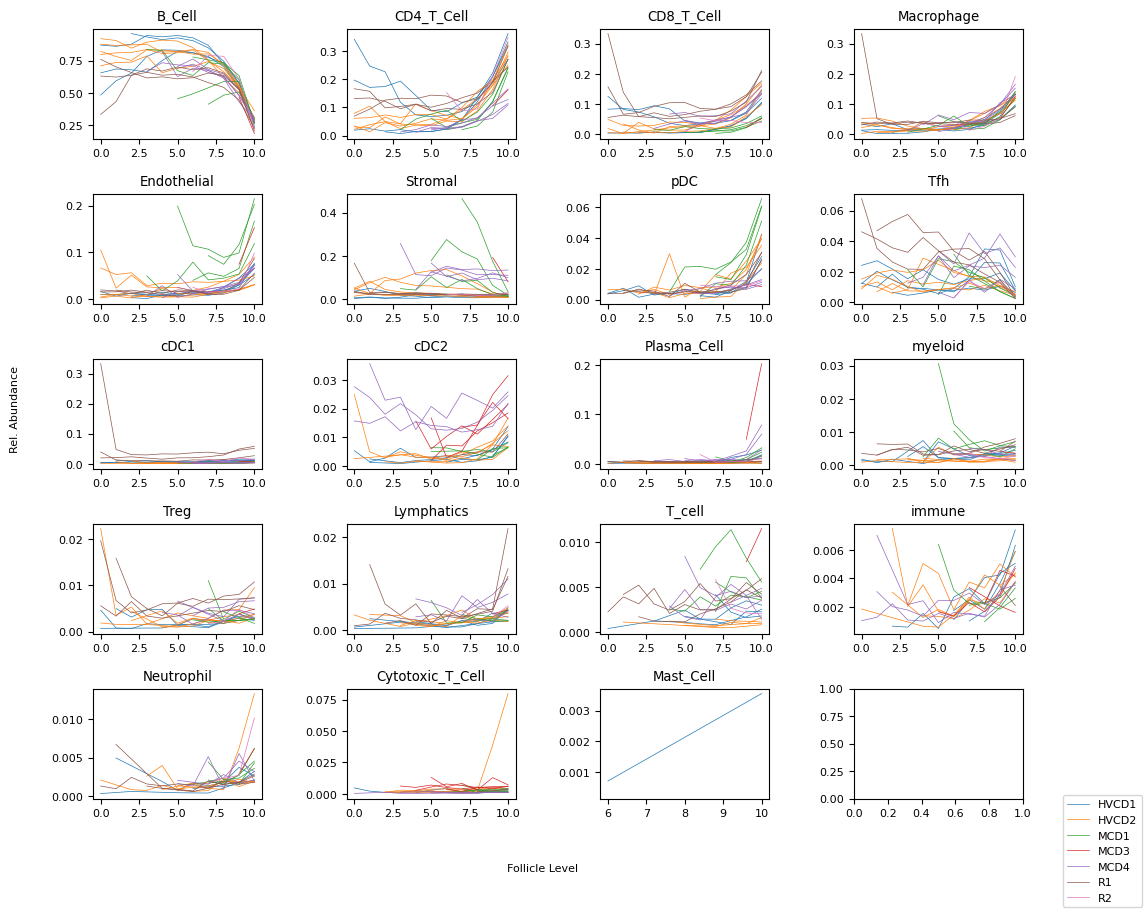

In [57]:
# !!run one example to get the legend information (like above)!!
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(12,10))
ax = ax.ravel()

for i in range(19):
    ct = plot_cells.index[i]
    meta = codex.obs.copy()
    meta = meta.loc[(meta.new_pheno == ct) & (meta.follicle_level != -1),:]
    meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
           'fuse_pheno']]
    pdata = meta.groupby(["region", "follicle", "follicle_level"], as_index=True).agg(
        **{
            "size": pd.NamedAgg(column="new_pheno", aggfunc="size"),
            "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
        })
    pdata = pdata.join(level_sizes)
    pdata['rel_size'] = pdata['size']/pdata['absolute_size']
    pdata2 = pdata.groupby(["region", "follicle_level"], as_index=True)[["rel_size"]].mean()
    pdata2.reset_index(inplace=True)
    pdata2[["donor","reg"]] = pdata2[["region"]].apply(lambda x: x[0].split("_"), axis=1, result_type="expand")
    pdata2['disease'] = pdata2[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)

    sns.lineplot(data=pdata2, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x='follicle_level',
             y='rel_size',
             hue='donor',
                units='region',
                estimator=None,
                lw=0.5,
                 ax=ax[i],
                 legend=False
                )
    ax[i].set_title(ct)
    ax[i].xaxis.label.set_visible(False)
    ax[i].yaxis.label.set_visible(False)
    # plt.xticks(rotation=90)

handles, labels = p.get_legend_handles_labels()
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
# fig.legend(labels, loc='lower right', bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)
fig.legend(handles, labels, loc='lower right')
fig.text(0.5, 0.04, 'Follicle Level', ha='center', va='center')
fig.text(0.06, 0.5, 'Rel. Abundance', ha='center', va='center', rotation='vertical')
# plt.tight_layout()
plt.savefig('outs/contour100/lines_donor_origCellTypes_v1.pdf')

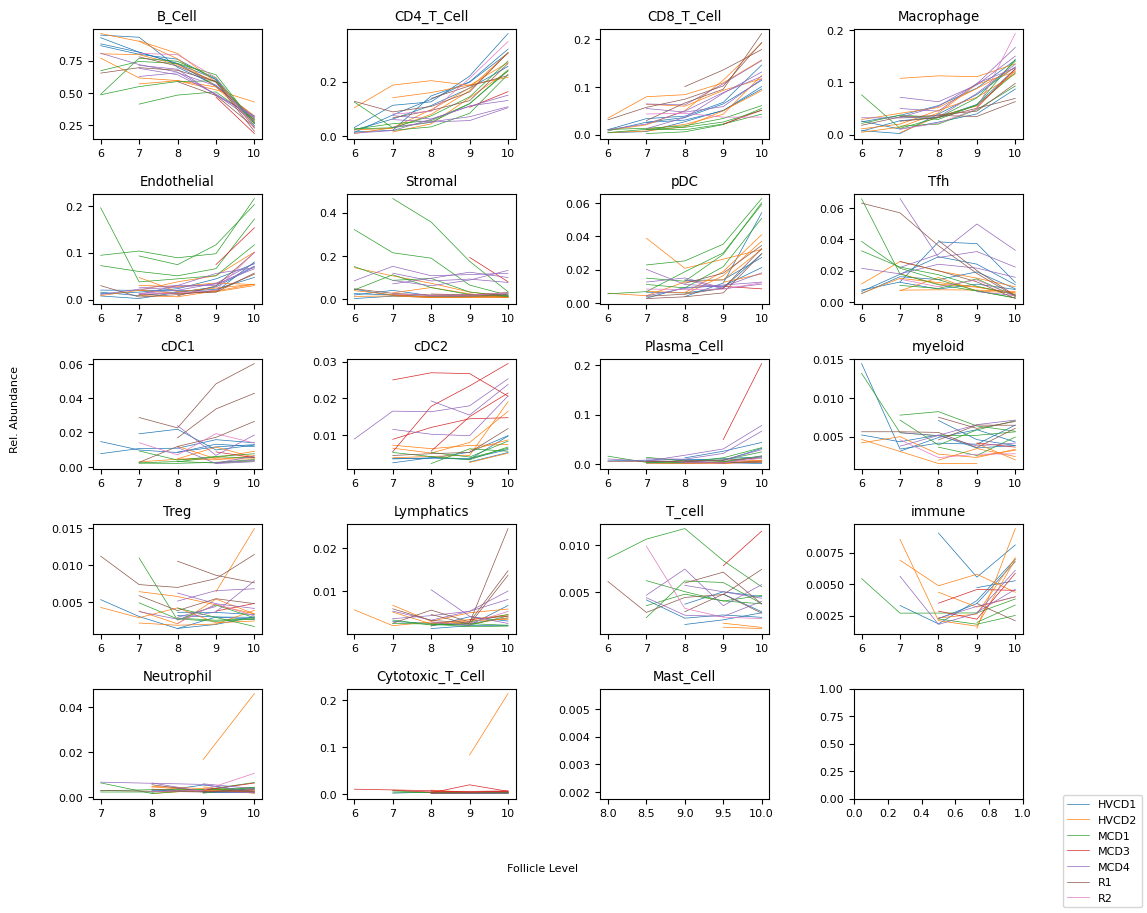

In [58]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(12,10))
ax = ax.ravel()

for i in range(19):
    ct = plot_cells.index[i]
    meta = codex.obs.copy()
    meta = meta.loc[(meta.new_pheno == ct) & (meta.follicle_level != -1) & (meta.follicle_area < size_quants.iloc[0]+1),:]
    meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
           'fuse_pheno']]
    pdata = meta.groupby(["region", "follicle", "follicle_level"], as_index=True).agg(
        **{
            "size": pd.NamedAgg(column="new_pheno", aggfunc="size"),
            "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
        })
    pdata = pdata.join(level_sizes)
    pdata['rel_size'] = pdata['size']/pdata['absolute_size']
    pdata2 = pdata.groupby(["region", "follicle_level"], as_index=True)[["rel_size"]].mean()
    pdata2.reset_index(inplace=True)
    pdata2[["donor","reg"]] = pdata2[["region"]].apply(lambda x: x[0].split("_"), axis=1, result_type="expand")
    pdata2['disease'] = pdata2[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)

    sns.lineplot(data=pdata2, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x='follicle_level',
             y='rel_size',
             hue='donor',
                units='region',
                estimator=None,
                lw=0.5,
                 ax=ax[i],
                 legend=False
                )
    ax[i].set_title(ct)
    ax[i].xaxis.label.set_visible(False)
    ax[i].yaxis.label.set_visible(False)
    # plt.xticks(rotation=90)

handles, labels = p.get_legend_handles_labels()
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
# fig.legend(labels, loc='lower right', bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)
fig.legend(handles, labels, loc='lower right')
fig.text(0.5, 0.04, 'Follicle Level', ha='center', va='center')
fig.text(0.06, 0.5, 'Rel. Abundance', ha='center', va='center', rotation='vertical')
# plt.tight_layout()
plt.savefig('outs/contour100/lines_donor_smallFoll_origCellTypes_v1.pdf')

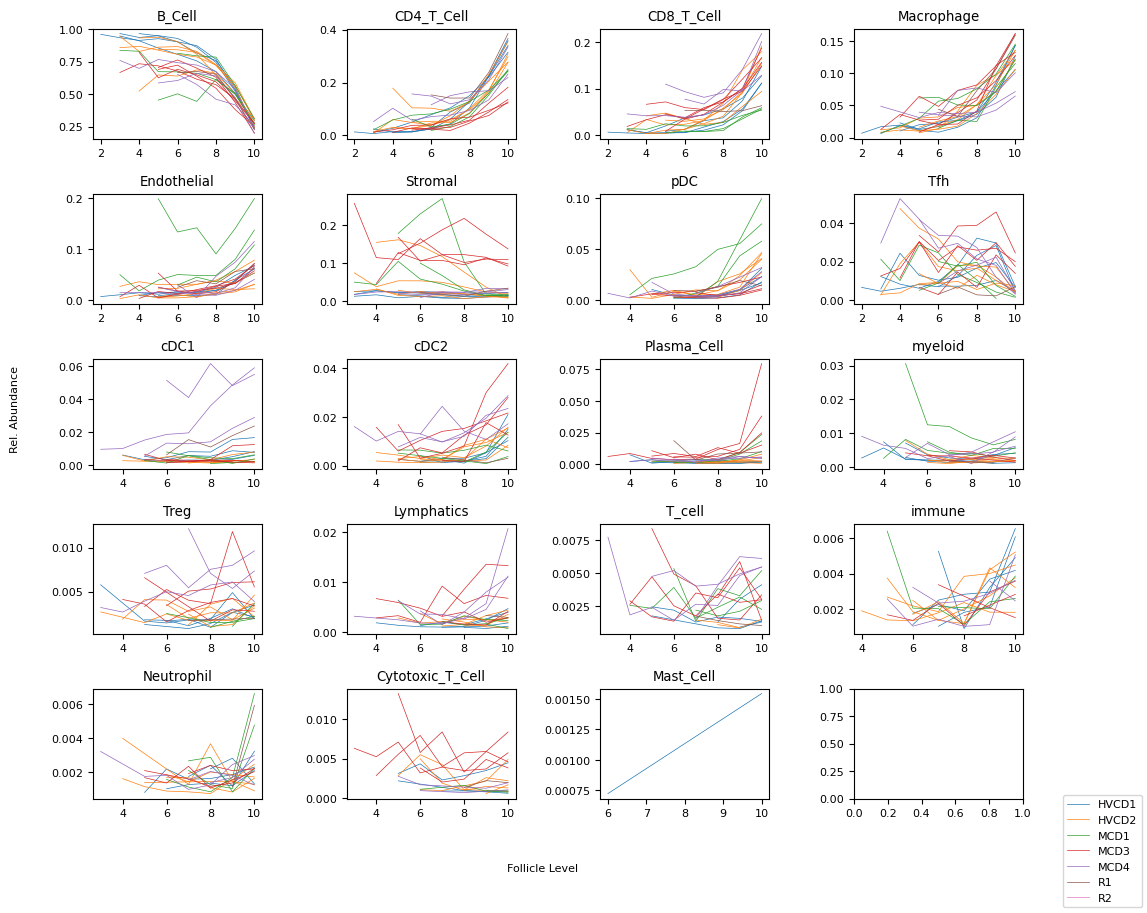

In [59]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(12,10))
ax = ax.ravel()

for i in range(19):
    ct = plot_cells.index[i]
    meta = codex.obs.copy()
    meta = meta.loc[(meta.new_pheno == ct) & (meta.follicle_level != -1) & (meta.follicle_area > size_quants.iloc[0]+1) & (meta.follicle_area < size_quants.iloc[1]+1),:]
    meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
           'fuse_pheno']]
    pdata = meta.groupby(["region", "follicle", "follicle_level"], as_index=True).agg(
        **{
            "size": pd.NamedAgg(column="new_pheno", aggfunc="size"),
            "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
        })
    pdata = pdata.join(level_sizes)
    pdata['rel_size'] = pdata['size']/pdata['absolute_size']
    pdata2 = pdata.groupby(["region", "follicle_level"], as_index=True)[["rel_size"]].mean()
    pdata2.reset_index(inplace=True)
    pdata2[["donor","reg"]] = pdata2[["region"]].apply(lambda x: x[0].split("_"), axis=1, result_type="expand")
    pdata2['disease'] = pdata2[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)

    sns.lineplot(data=pdata2, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x='follicle_level',
             y='rel_size',
             hue='donor',
                units='region',
                estimator=None,
                lw=0.5,
                 ax=ax[i],
                 legend=False
                )
    ax[i].set_title(ct)
    ax[i].xaxis.label.set_visible(False)
    ax[i].yaxis.label.set_visible(False)
    # plt.xticks(rotation=90)

handles, labels = p.get_legend_handles_labels()
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
# fig.legend(labels, loc='lower right', bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)
fig.legend(handles, labels, loc='lower right')
fig.text(0.5, 0.04, 'Follicle Level', ha='center', va='center')
fig.text(0.06, 0.5, 'Rel. Abundance', ha='center', va='center', rotation='vertical')
# plt.tight_layout()
plt.savefig('outs/contour100/lines_donor_mediumFoll_origCellTypes_v1.pdf')

<Axes: xlabel='follicle_level', ylabel='rel_size'>

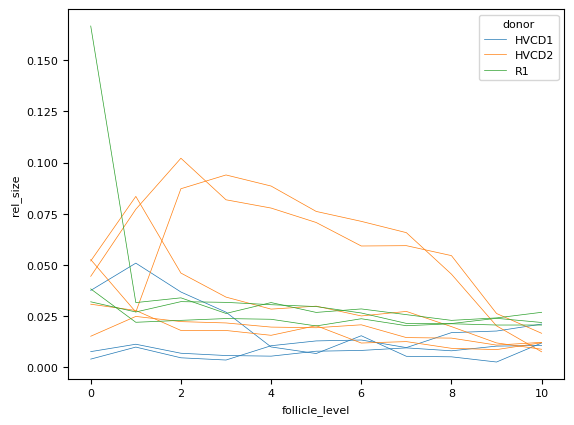

In [63]:
i = 5
ct = plot_cells.index[i]
meta = codex.obs.copy()
meta = meta.loc[(meta.new_pheno == ct) & (meta.follicle_level != -1) & (meta.follicle_area > size_quants.iloc[1]+1),:]
meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
           'fuse_pheno']]
pdata = meta.groupby(["region", "follicle", "follicle_level"], as_index=True).agg(
    **{
        "size": pd.NamedAgg(column="new_pheno", aggfunc="size"),
        "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
    })
pdata = pdata.join(level_sizes)
pdata['rel_size'] = pdata['size']/pdata['absolute_size']
pdata2 = pdata.groupby(["region", "follicle_level"], as_index=True)[["rel_size"]].mean()
pdata2.reset_index(inplace=True)
pdata2[["donor","reg"]] = pdata2[["region"]].apply(lambda x: x[0].split("_"), axis=1, result_type="expand")
pdata2['disease'] = pdata2[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)

sns.lineplot(data=pdata2, 
         # x=avg_df.index.get_level_values('cell_type'),
             x='follicle_level',
         y='rel_size',
         hue='donor',
            units='region',
            estimator=None,
            lw=0.5
            )

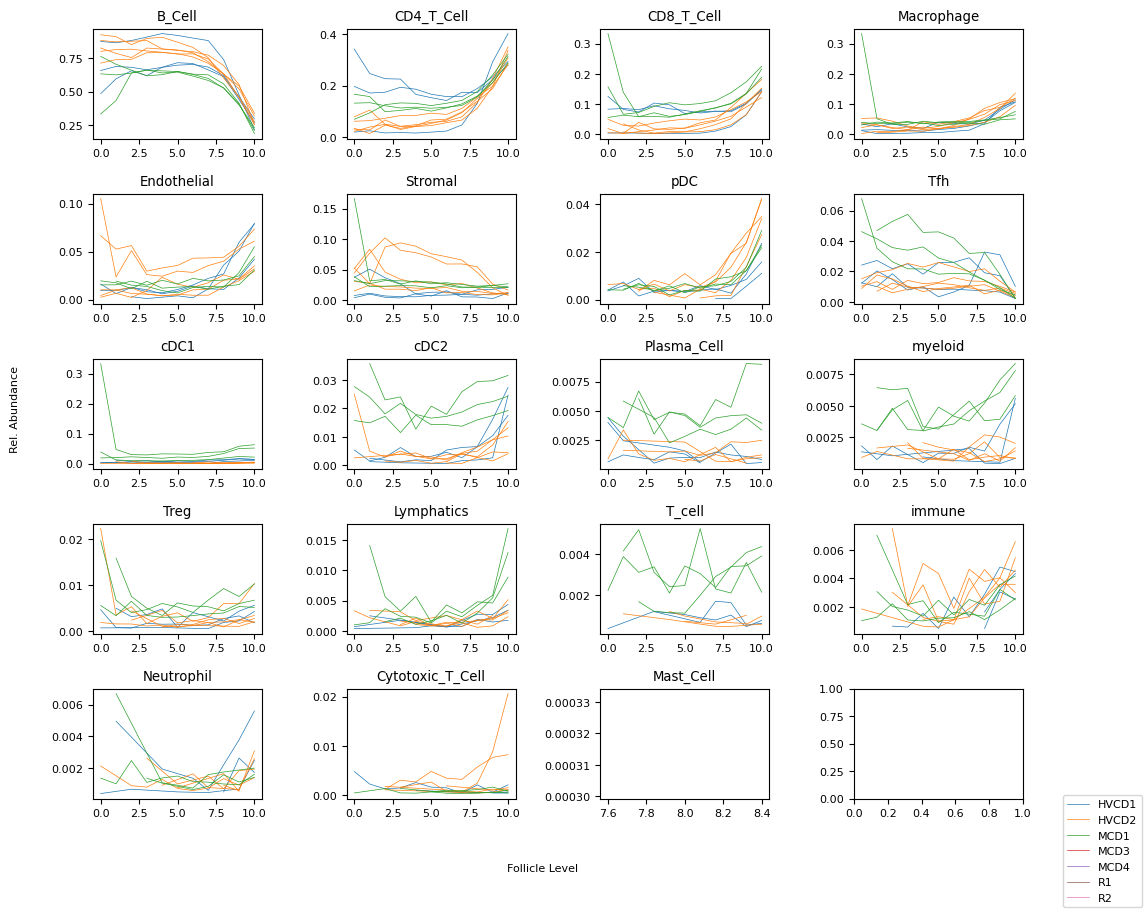

In [60]:
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(12,10))
ax = ax.ravel()

for i in range(19):
    ct = plot_cells.index[i]
    meta = codex.obs.copy()
    meta = meta.loc[(meta.new_pheno == ct) & (meta.follicle_level != -1) & (meta.follicle_area > size_quants.iloc[1]+1),:]
    meta = meta[['new_pheno', 'region', 'follicle', 'follicle_level', 'follicle_area',
           'fuse_pheno']]
    pdata = meta.groupby(["region", "follicle", "follicle_level"], as_index=True).agg(
        **{
            "size": pd.NamedAgg(column="new_pheno", aggfunc="size"),
            "scaled_area": pd.NamedAgg(column="follicle_area", aggfunc=lambda x: (np.log(x)/max_scale).mean())
        })
    pdata = pdata.join(level_sizes)
    pdata['rel_size'] = pdata['size']/pdata['absolute_size']
    pdata2 = pdata.groupby(["region", "follicle_level"], as_index=True)[["rel_size"]].mean()
    pdata2.reset_index(inplace=True)
    pdata2[["donor","reg"]] = pdata2[["region"]].apply(lambda x: x[0].split("_"), axis=1, result_type="expand")
    pdata2['disease'] = pdata2[["donor"]].apply(lambda x: re.search('\D*',x[0]).group(0), axis=1)

    sns.lineplot(data=pdata2, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x='follicle_level',
             y='rel_size',
             hue='donor',
                units='region',
                estimator=None,
                lw=0.5,
                 ax=ax[i],
                 legend=False
                )
    ax[i].set_title(ct)
    ax[i].xaxis.label.set_visible(False)
    ax[i].yaxis.label.set_visible(False)
    # plt.xticks(rotation=90)

handles, labels = p.get_legend_handles_labels()
plt.subplots_adjust(hspace=0.5, wspace = 0.5)
# fig.legend(labels, loc='lower right', bbox_to_anchor=(1,-0.1), ncol=len(labels), bbox_transform=fig.transFigure)
fig.legend(handles, labels, loc='lower right')
fig.text(0.5, 0.04, 'Follicle Level', ha='center', va='center')
fig.text(0.06, 0.5, 'Rel. Abundance', ha='center', va='center', rotation='vertical')
# plt.tight_layout()
# plt.savefig('outs/contour100/lines_donor_largeFoll_origCellTypes_v1.pdf')

# Old stuff

In [92]:
new_df = all_fl_df.groupby(['donor', 'region', 'follicle'])[['cells']].apply(lambda x: x/x.sum())
all_fl_df['rel_counts'] = new_df.sort_index(level=3)[['cells']].values
# now average relative abundance by donor, region, cell_type
avg_df = all_fl_df.groupby(['donor', 'region', 'cell_type'])[['rel_counts']].mean()
avg_df['name'] = avg_df.index.map(lambda x: '_'.join([x[0],x[1]]))
avg_df['disease'] = avg_df.index.map(lambda x: re.search('\D*',x[0]).group(0))
ct_order = avg_df.groupby(level=2).mean('rel_counts').sort_values('rel_counts', ascending=False)
cts = pd.Categorical(avg_df.index.get_level_values('cell_type'), 
                    categories=ct_order.index,
                    ordered=True)

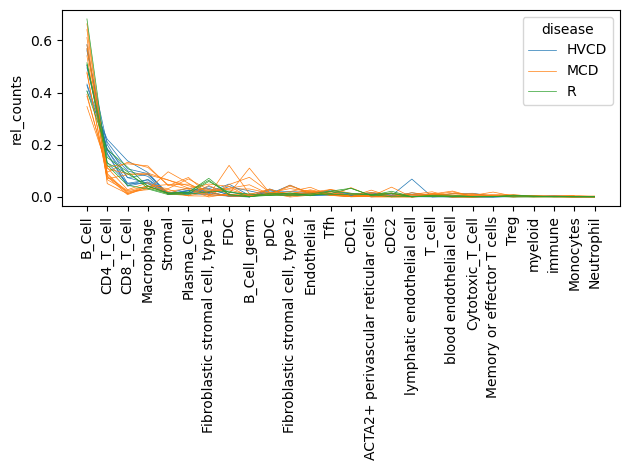

In [93]:
p = sns.lineplot(data=avg_df, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x=cts,
             y='rel_counts',
             hue='disease',
                units='name',
                estimator=None,
                lw=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
p
plt.savefig('outs/mantle200_MaxFuse_celltypes_v1.pdf')

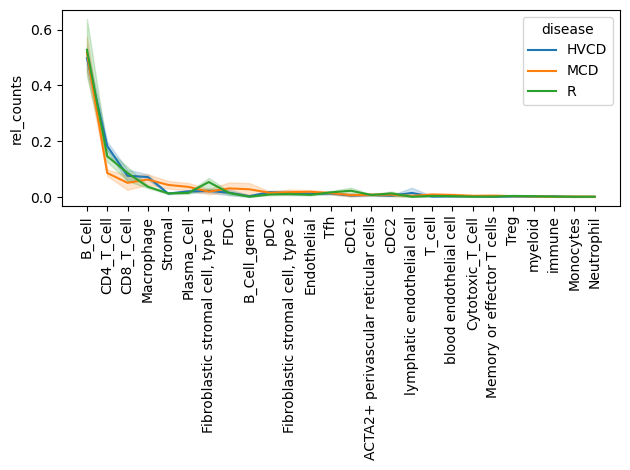

In [94]:
p = sns.lineplot(data=avg_df, 
             # x=avg_df.index.get_level_values('cell_type'),
                 x=cts,
             y='rel_counts',
             hue='disease')
plt.xticks(rotation=90)
plt.tight_layout()
p
plt.savefig('outs/mantle200_MaxFuse_celltypes_v2.pdf')

In [ ]:
aall_fl_dat = []
codex.obs['follicle'] = 0
codex.obs['follicle_level'] = -1
codex.obs['follicle_area'] = 0
for full_r in tqdm(codex.obs.region.unique()):
    print(full_r)
    adata = codex[codex.obs.region == full_r,:]
    all_coords = adata.obs[['Absolute.Y', 'Absolute.X']].to_numpy()
    all_coords = gpd.points_from_xy(x=all_coords[:,1], y=all_coords[:,0])
    r_ = full_r.split("_")
    sname = r_[0]
    regname = r_[1]

    # getting the data
    coords = adata.obs[['Absolute.Y', 'Absolute.X']].to_numpy() # should it be X,Y or Y,X ????
    coords = coords[adata.obs.motif.isin(['Motif_2', 'Motif_4']),:]

    # getting the follicles
    clustered = []
    follicle_sets = []
    for i in range(coords.shape[0]):
        if i not in clustered:
            i_dist = np.linalg.norm(coords[i]-coords, axis=1)
            i_neighbor = np.where(i_dist < 50)[0].tolist()
            # should we check whether any of the neighbors are in the clustered list?
            # i_neighbor = i_neighbor[~list(map(lambda i_: i_ in clustered, i_neighbor))]
            clustered.extend(i_neighbor)
            
            new_cl_token = 1
            fs_hits = [fi for fi in range(len(follicle_sets)) if len(set(follicle_sets[fi]).intersection(i_neighbor)) > 0]
            if len(fs_hits) > 0:
                cell_set = []
                for fi in sorted(fs_hits, reverse=True):
                    cell_set.extend(follicle_sets[fi])
                    follicle_sets.pop(fi)
                cell_set = set(cell_set).union(i_neighbor)
                follicle_sets.append(cell_set)
            else:
                follicle_sets.append(i_neighbor)


    # filtering follicles
    f_clust = []
    keep_i = []
    cl_i = 1
    for fs in follicle_sets:
        if len(fs) > 200:
            f_clust.extend(np.repeat(cl_i, len(fs)))
            keep_i.extend(fs)
            cl_i += 1
    follicle_filt = pd.DataFrame({'f_clust':f_clust,
                                 'celli':keep_i})

    # Getting the follicle data
    fl_dfs = []
    for f in follicle_filt.f_clust.unique():
        coords_test = coords[follicle_filt.celli.loc[follicle_filt.f_clust==f].values,:]
        foll_hull = ConvexHull(coords_test)
        foll_geom = np.flip(foll_hull.points[foll_hull.vertices], 1)
        foll_poly = shp.Polygon(foll_geom)
        foll_poly = foll_poly.buffer(-200, single_sided=True)
        mantle = foll_poly.buffer(100, single_sided=False)
        mantle_c = all_coords.within(mantle - foll_poly)
        res_df = pd.DataFrame({'donor':sname, 
                               'region':regname, 
                               'follicle':'fl'+str(f), 
                               'cells': adata.obs.new_pheno.loc[mantle_c].value_counts().values,
                               'cell_type': adata.obs.new_pheno.loc[mantle_c].value_counts().index})
        fl_dfs.append(res_df)
    fl_df = pd.concat(fl_dfs, axis=0, ignore_index=True)
    all_fl_dat.append(fl_df)